


## **Customer Segmentation**


---

# PHASE 1
---------

## 1.1 Introduction

In this project, we aim to explore customer segmentation by applying various unsupervised learning techniques on a dataset containing customer information from a mall. The primary goal is to divide the customer base into meaningful segments that reveal valuable insights for marketing and business strategies.

The implementation of this project follows a structured approach, starting with a thorough understanding of the dataset and its attributes. Data cleaning techniques are applied to ensure the data is accurate, consistent, and free from anomalies. Outliers are detected and handled appropriately to avoid skewing the analysis. Several clustering methods are employed to group customers.

To enhance the understanding of the results, a variety of visualization methods are used to represent the data and clustering outputs. The project also emphasizes experimentation with different preprocessing techniques and clustering models, including those not covered in the coursework, to improve accuracy and explore innovative approaches.

Through this comprehensive analysis, the project aims to demonstrate the power of data mining techniques in extracting actionable insights from raw data and highlight the importance of customer segmentation in modern business practices.

## 1.2 Preprocessing

### 1.2.1 imports

In [404]:
pip install numpy pandas scikit-learn apyori pyfpgrowth seaborn matplotlib scipy scikit-learn-extra

In [405]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.mixture import GaussianMixture

from apyori import apriori
import pyfpgrowth
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import fcluster

### 1.2.2 loading data

In [406]:
df = pd.read_csv('Mall_Customers.csv')
print(df.head())
print(df.info())
print(df.describe())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  

In [407]:
data = df.drop(columns=['CustomerID'])
data.head()

Gender  Age  Annual Income (k$)  Spending Score (1-100)
0    Male   19                  15                      39
1    Male   21                  15                      81
2  Female   20                  16                       6
3  Female   23                  16                      77
4  Female   31                  17                      40

In [408]:
# no missing data

if data.isnull().sum().sum() == 0:
    print("No missing values detected.")
else:
    print("Missing values detected. Handling them...")

No missing values detected.


### 1.2.3 General observation


In [409]:
male_count = data[data["Gender"] == "Male"].shape[0]
print(male_count)
Female_count = data[data["Gender"] == "Female"].shape[0]
print(Female_count)

88
112


   - The average customer age is around 39 years and Customer ages vary by about 14 years from the average.
   - The average annual income of customers is about $60,560 and it varies by approximately $26,260 from the average
   - The average spending score is approximately 50 (mid-range) and vary by about 26 points from the average
   - 75% of the data falls below (third quartile).
   - Customers have a wide age range (18–70), indicating diversity in the customer base.
   - Annual incomes range from $15,000 to $137,000, showing significant financial diversity.
   - Spending scores vary from 1 to 99, indicating customers with both minimal and very high engagement.
   - The mean spending score (50) indicates a balanced spending behavior overall.

## 1.3 Outliers Detection and Removal

### 1.3.1 Detection

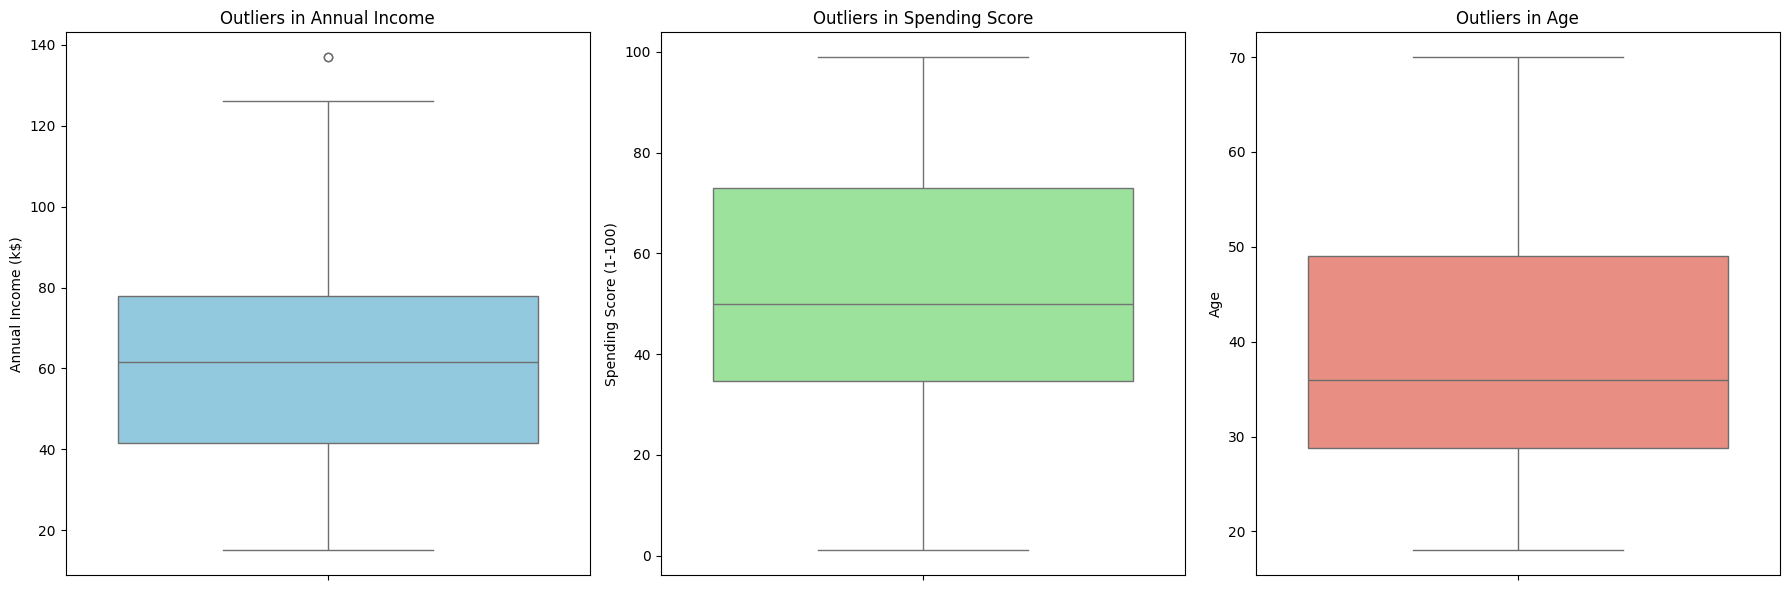

In [410]:
# Boxplots for Outlier Detection
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data['Annual Income (k$)'], ax=axes[0], color='skyblue')
axes[0].set_title('Outliers in Annual Income')

sns.boxplot(data['Spending Score (1-100)'], ax=axes[1], color='lightgreen')
axes[1].set_title('Outliers in Spending Score')

sns.boxplot(data['Age'], ax=axes[2], color='salmon')
axes[2].set_title('Outliers in Age')

plt.tight_layout()
plt.show()

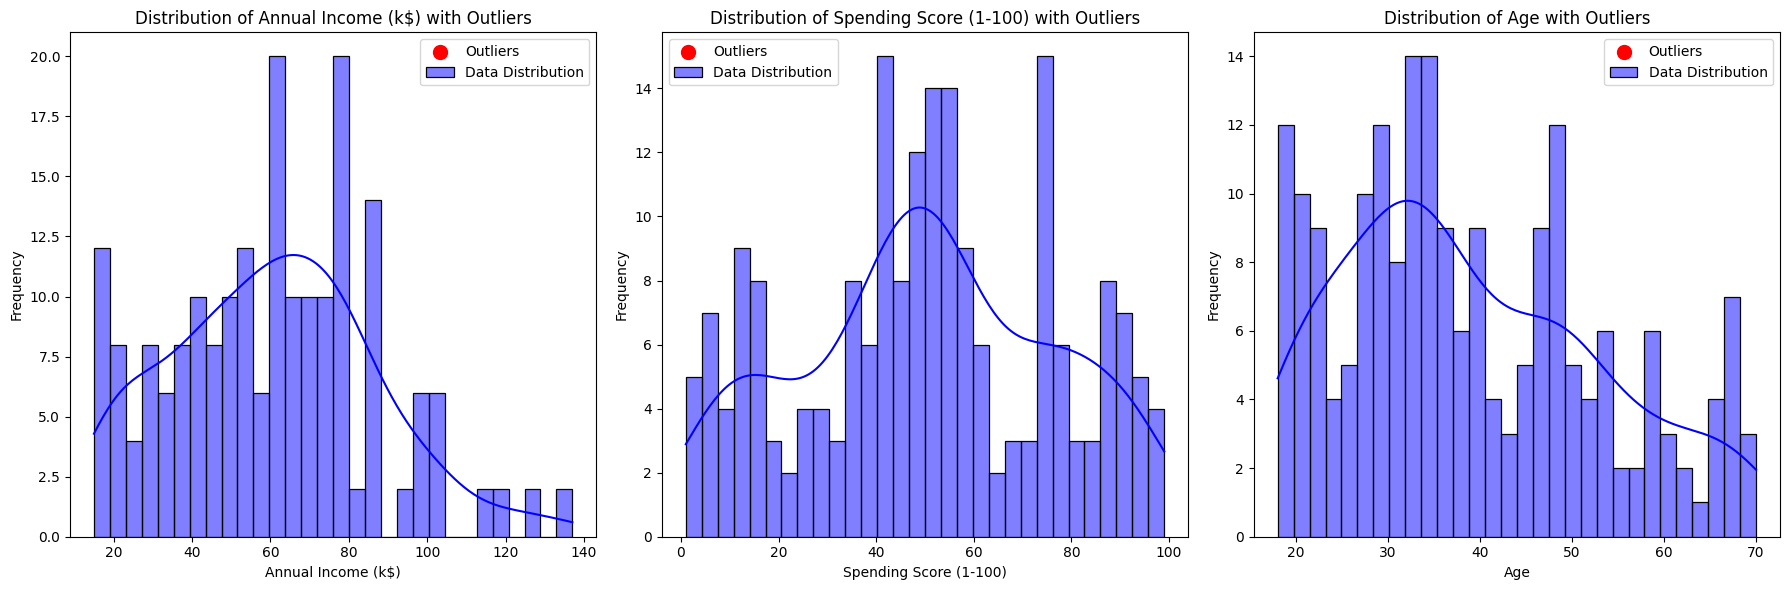

In [411]:
def detect_outliers_zscore(data, column_name, ax):
    # Calculate Z-scores
    data['z_score'] = (data[column_name] - data[column_name].mean()) / data[column_name].std()

    # Identify outliers as data points with |Z-score| > 3
    outliers = data[np.abs(data['z_score']) > 3]

    # Plot the distribution and highlight outliers
    sns.histplot(data[column_name], bins=30, kde=True, color='blue', label='Data Distribution', ax=ax)
    ax.scatter(outliers[column_name], [0] * len(outliers), color='red', label='Outliers', s=100, zorder=3)
    ax.set_title(f'Distribution of {column_name} with Outliers')
    ax.set_xlabel(column_name)
    ax.set_ylabel('Frequency')
    ax.legend()

    # Drop Z-score column for cleanliness
    data.drop(columns=['z_score'], inplace=True)

    return outliers


# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of features to check for outliers
features_to_check = ['Annual Income (k$)', 'Spending Score (1-100)', 'Age']

# Dictionary to store outliers
outliers_dict = {}

# Loop through each feature and plot side by side
for i, feature in enumerate(features_to_check):
    outliers = detect_outliers_zscore(data, feature, axes[i])
    outliers_dict[feature] = outliers

# Show all plots
plt.tight_layout()
plt.show()

### 1.3.2 Observations after outliers detection

- Annual Income shows a right-skewed distribution, with most data points concentrated between 40k and 80k, and a few outliers below 20k and above 120k.
- Spending Score has a bimodal distribution, peaking around 20–40 and 60–80, with outliers near 0 and 100 indicating unusual spending behaviors.
- Age data is roughly symmetric, with most values centered around 25–35, while outliers appear at higher ages closer to 70. These outliers may indicate anomalies or unique cases that warrant further investigation.

### 1.3.3 Removal


Bounds for each feature:
Annual Income (k$): Lower = -13.25, Upper = 132.75
Spending Score (1-100): Lower = -21.62, Upper = 129.38
Age: Lower = -2.88, Upper = 80.12

Original number of rows: 200
Number of rows after removing outliers: 198


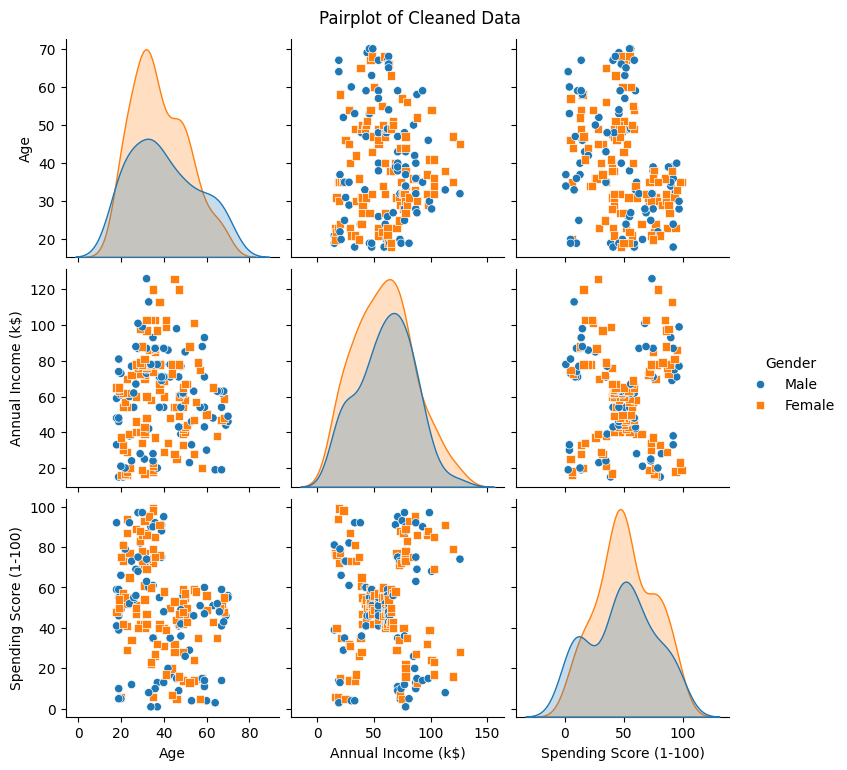

Data After Cleaning


In [412]:

# Function to calculate IQR bounds and filter outliers
def calculate_iqr_bounds(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return lower_bound, upper_bound

def filter_outliers(data, features, threshold=1.5):
    bounds = {}
    for feature in features:
        lower, upper = calculate_iqr_bounds(data, feature, threshold)
        bounds[feature] = (lower, upper)
        print(f"{feature}: Lower = {lower:.2f}, Upper = {upper:.2f}")
        data = data[(data[feature] >= lower) & (data[feature] <= upper)]
    return data, bounds

# Define features to analyze and the threshold for outliers
features = ['Annual Income (k$)', 'Spending Score (1-100)', 'Age']
threshold = 1.5

# Load data and filter out outliers
print("\nBounds for each feature:")
data_cleaned, bounds = filter_outliers(data, features, threshold)

# Display the number of rows before and after removing outliers
print(f"\nOriginal number of rows: {len(data)}")
print(f"Number of rows after removing outliers: {len(data_cleaned)}")

# Visualize cleaned data
sns.pairplot(data_cleaned, hue='Gender', diag_kind="kde", markers=["o", "s"])
plt.suptitle("Pairplot of Cleaned Data", y=1.02)
plt.show()


print("Data After Cleaning")
data_cleaned = pd.get_dummies(data_cleaned, columns=['Gender'])
data_cleaned.head()


data_cleaned_m=data_cleaned



## 1.4 Features Scalling

In [413]:
label_encoder = LabelEncoder()
data_cleaned['Gender_Female'] = label_encoder.fit_transform(data_cleaned['Gender_Female'])
data_cleaned['Gender_Male'] = label_encoder.fit_transform(data_cleaned['Gender_Male'])
data_cleaned.head()

Age  Annual Income (k$)  Spending Score (1-100)  Gender_Female  Gender_Male
0   19                  15                      39              0            1
1   21                  15                      81              0            1
2   20                  16                       6              1            0
3   23                  16                      77              1            0
4   31                  17                      40              1            0

In [414]:
data_standard = data_cleaned.copy()
data_minmax = data_cleaned.copy()

# Select numerical features to scale
numerical_features = ['Annual Income (k$)', 'Spending Score (1-100)', 'Age']

# Apply StandardScaler
scaler_standard = StandardScaler()
data_standard[numerical_features] = scaler_standard.fit_transform(data_standard[numerical_features])

# Apply MinMaxScaler
scaler_minmax = MinMaxScaler()
data_minmax[numerical_features] = scaler_minmax.fit_transform(data_minmax[numerical_features])

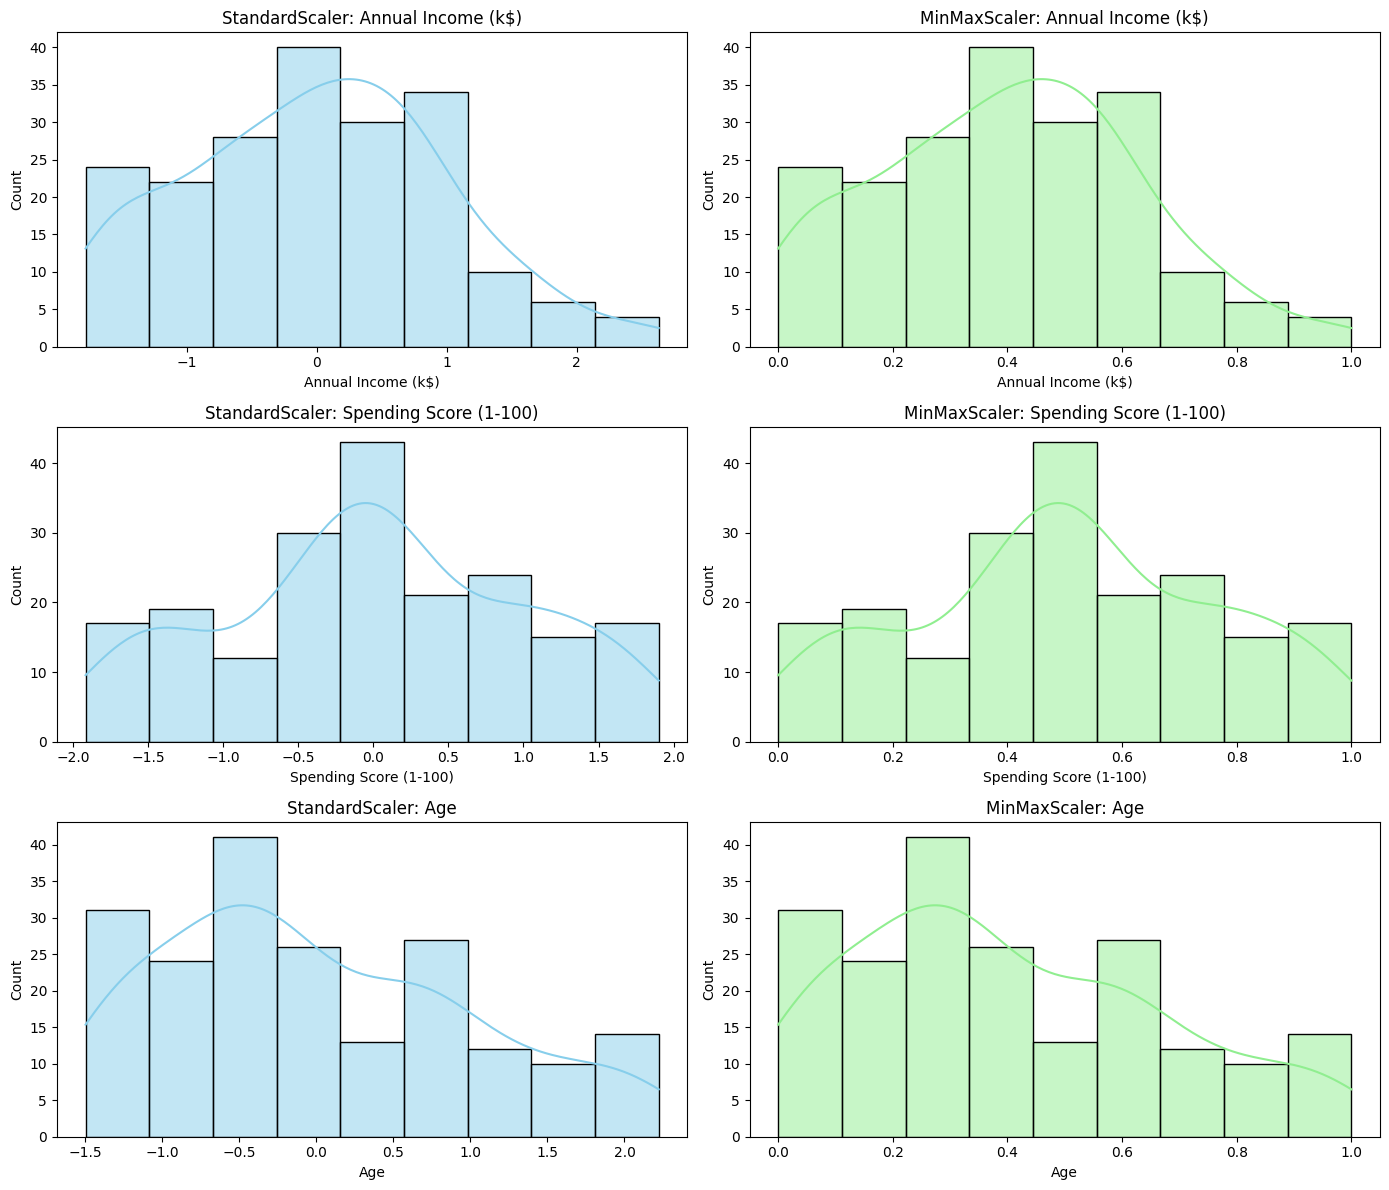

In [415]:
# Plot Histograms Side-by-Side for Each Scaler
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, feature in enumerate(numerical_features):
    # StandardScaler Plot
    sns.histplot(data_standard[feature], kde=True, color='skyblue', ax=axes[i, 0])
    axes[i, 0].set_title(f'StandardScaler: {feature}')

    # MinMaxScaler Plot
    sns.histplot(data_minmax[feature], kde=True, color='lightgreen', ax=axes[i, 1])
    axes[i, 1].set_title(f'MinMaxScaler: {feature}')

plt.tight_layout()
plt.show()

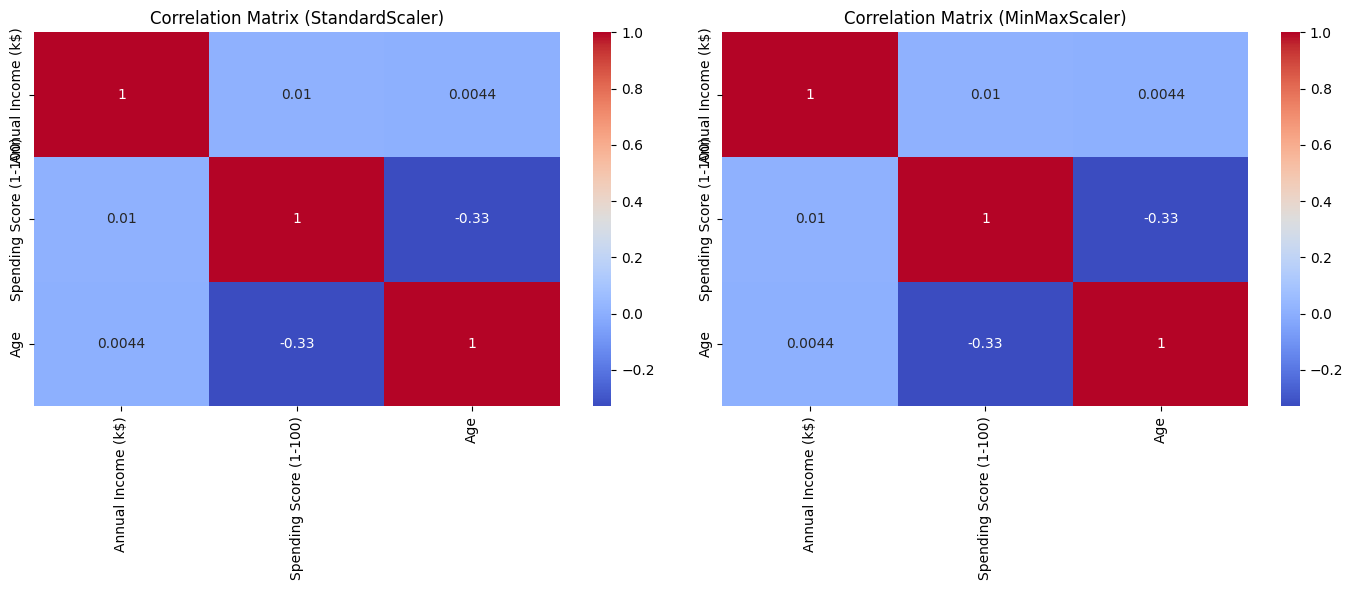

In [416]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation Matrix with StandardScaler
corr_standard = data_standard[numerical_features].corr()
sns.heatmap(corr_standard, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix (StandardScaler)')

# Correlation Matrix with MinMaxScaler
corr_minmax = data_minmax[numerical_features].corr()
sns.heatmap(corr_minmax, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix (MinMaxScaler)')

plt.tight_layout()
plt.show()

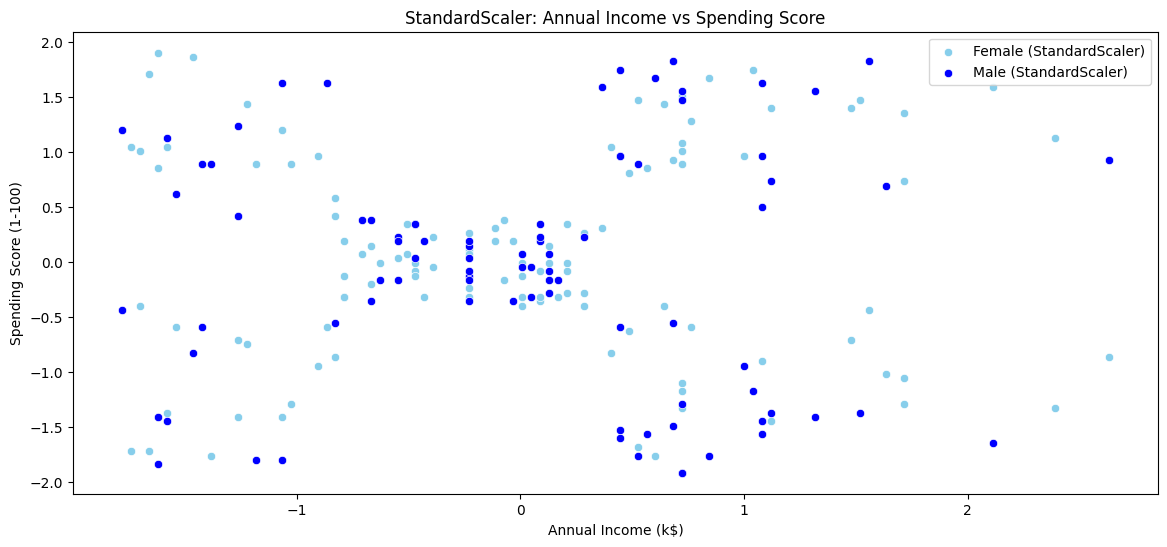

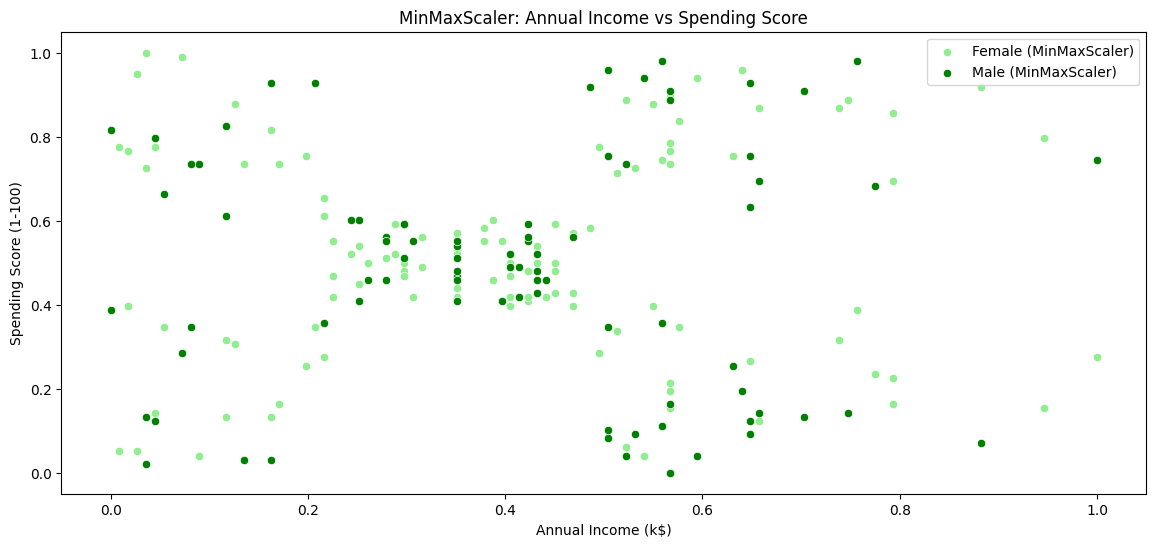

In [417]:
plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    data=data_standard[data_standard['Gender_Female'] == 1],
    label='Female (StandardScaler)',
    color='skyblue'
)
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    data=data_standard[data_standard['Gender_Male'] == 1],
    label='Male (StandardScaler)',
    color='blue'
)
plt.title('StandardScaler: Annual Income vs Spending Score')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    data=data_minmax[data_minmax['Gender_Female'] == 1],
    label='Female (MinMaxScaler)',
    color='lightgreen'
)
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    data=data_minmax[data_minmax['Gender_Male'] == 1],
    label='Male (MinMaxScaler)',
    color='green'
)
plt.title('MinMaxScaler: Annual Income vs Spending Score')
plt.legend()
plt.show()

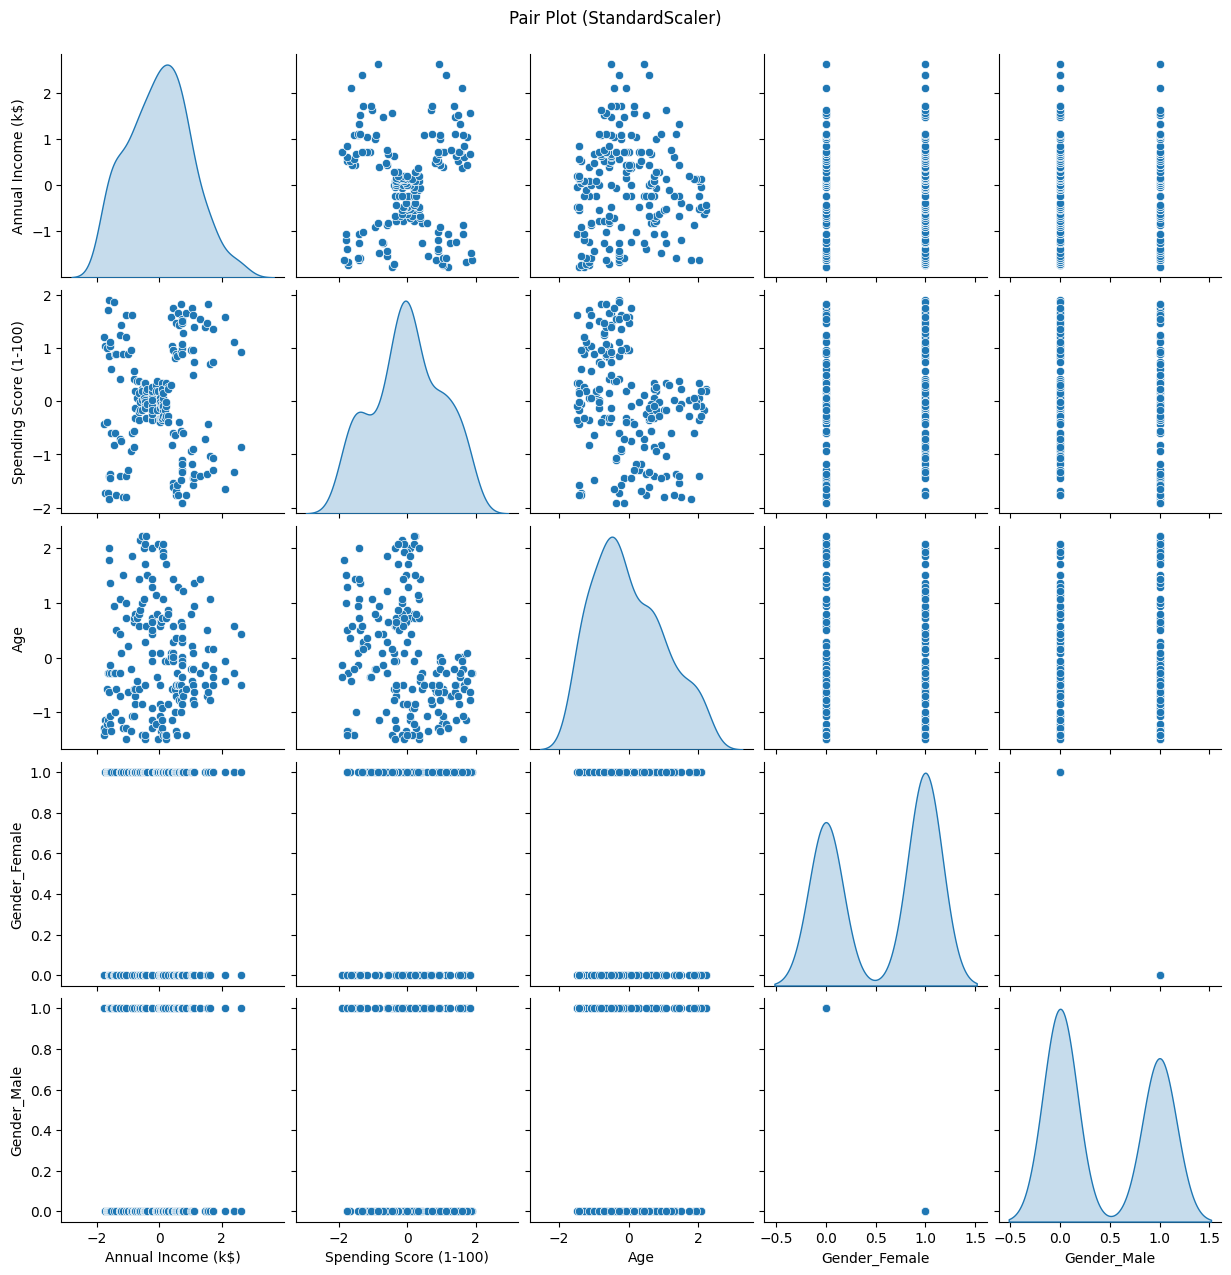

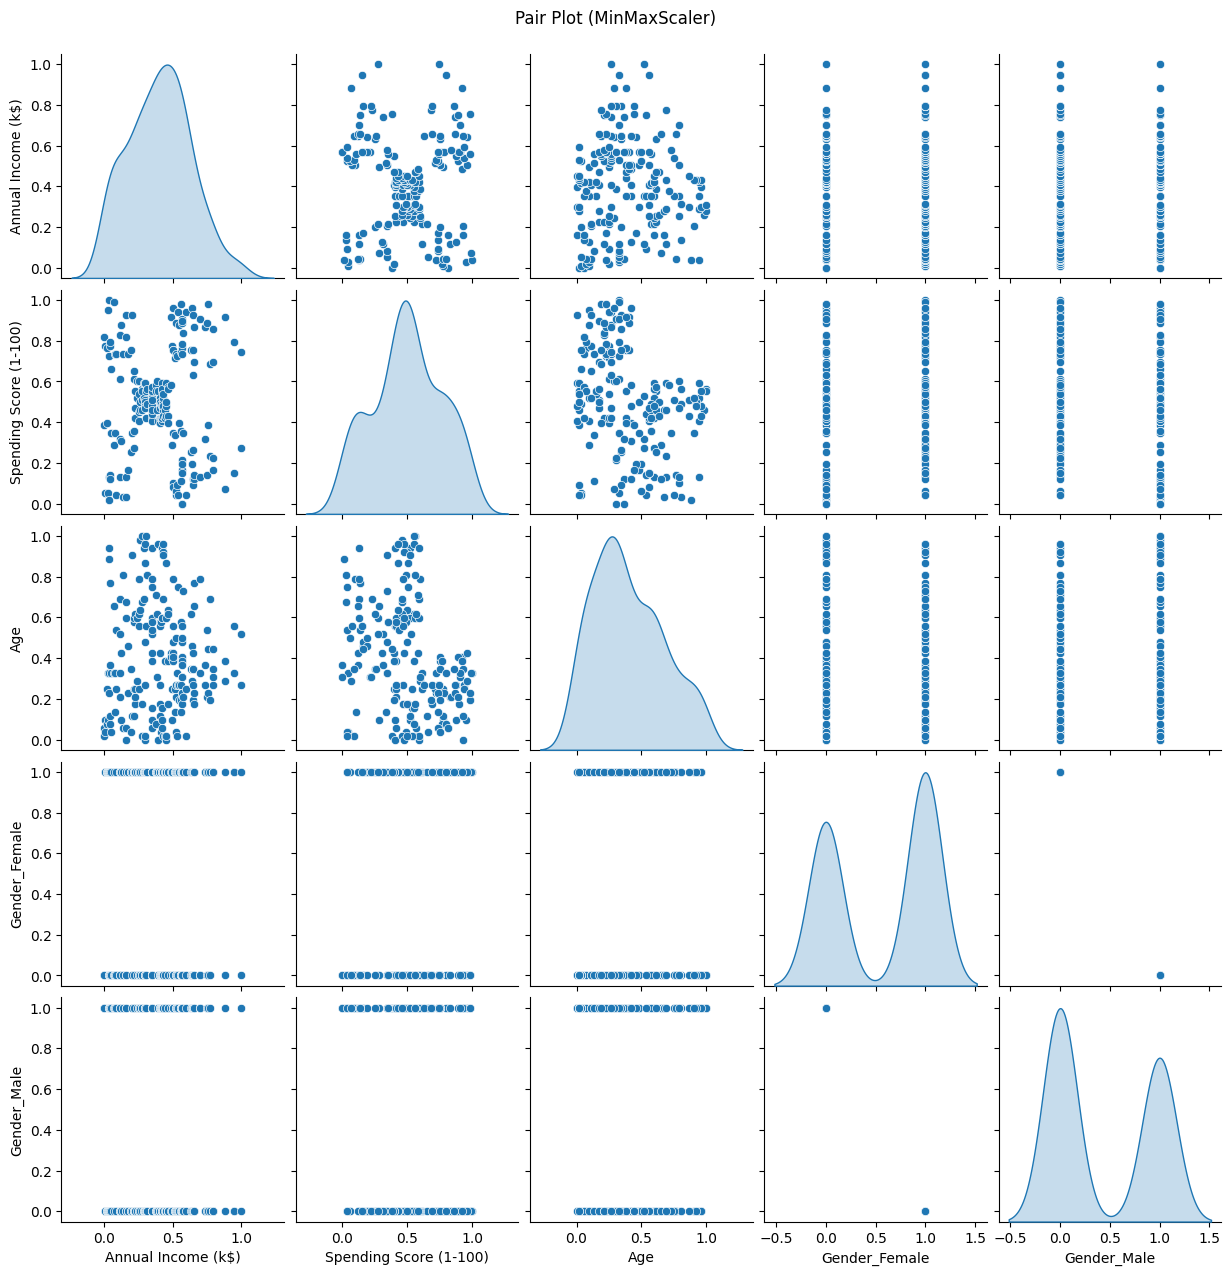

In [418]:
sns.pairplot(data_standard[numerical_features + ['Gender_Female', 'Gender_Male']], diag_kind='kde')
plt.suptitle('Pair Plot (StandardScaler)', y=1.02)
plt.show()


sns.pairplot(data_minmax[numerical_features + ['Gender_Female', 'Gender_Male']], diag_kind='kde')
plt.suptitle('Pair Plot (MinMaxScaler)', y=1.02)
plt.show()

# PHASE 2
----------------------------------------------------------------------------------------------

## 2.1 Clustering Models

### 2.1.1 K-Mean clustering

In [419]:

def kmeans_clustering(data, numerical_features, cluster_values, feature_pairs):
    # Create a grid of subplots
    fig, axes = plt.subplots(len(feature_pairs), len(cluster_values),
                             figsize=(18, 12), constrained_layout=True)
    fig.suptitle('KMeans Clustering Results Across Parameter Grid', fontsize=16)

    # Loop through feature pairs and cluster values
    for i, pair in enumerate(feature_pairs):
        for j, n_clusters in enumerate(cluster_values):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            data['KMeans_Labels'] = kmeans.fit_predict(data[pair])

            # Plot on the corresponding subplot
            ax = axes[i, j]
            scatter = ax.scatter(
                data[pair[0]],
                data[pair[1]],
                c=data['KMeans_Labels'],
                cmap='viridis',
                s=50,
                edgecolor='k'
            )
            ax.set_title(f'{pair[0]} vs {pair[1]} (k={n_clusters})', fontsize=10)
            ax.set_xlabel(pair[0], fontsize=9)
            ax.set_ylabel(pair[1], fontsize=9)
            ax.tick_params(axis='both', labelsize=8)

    # Add a shared colorbar to the figure
    fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04, label='Cluster')

    plt.show()

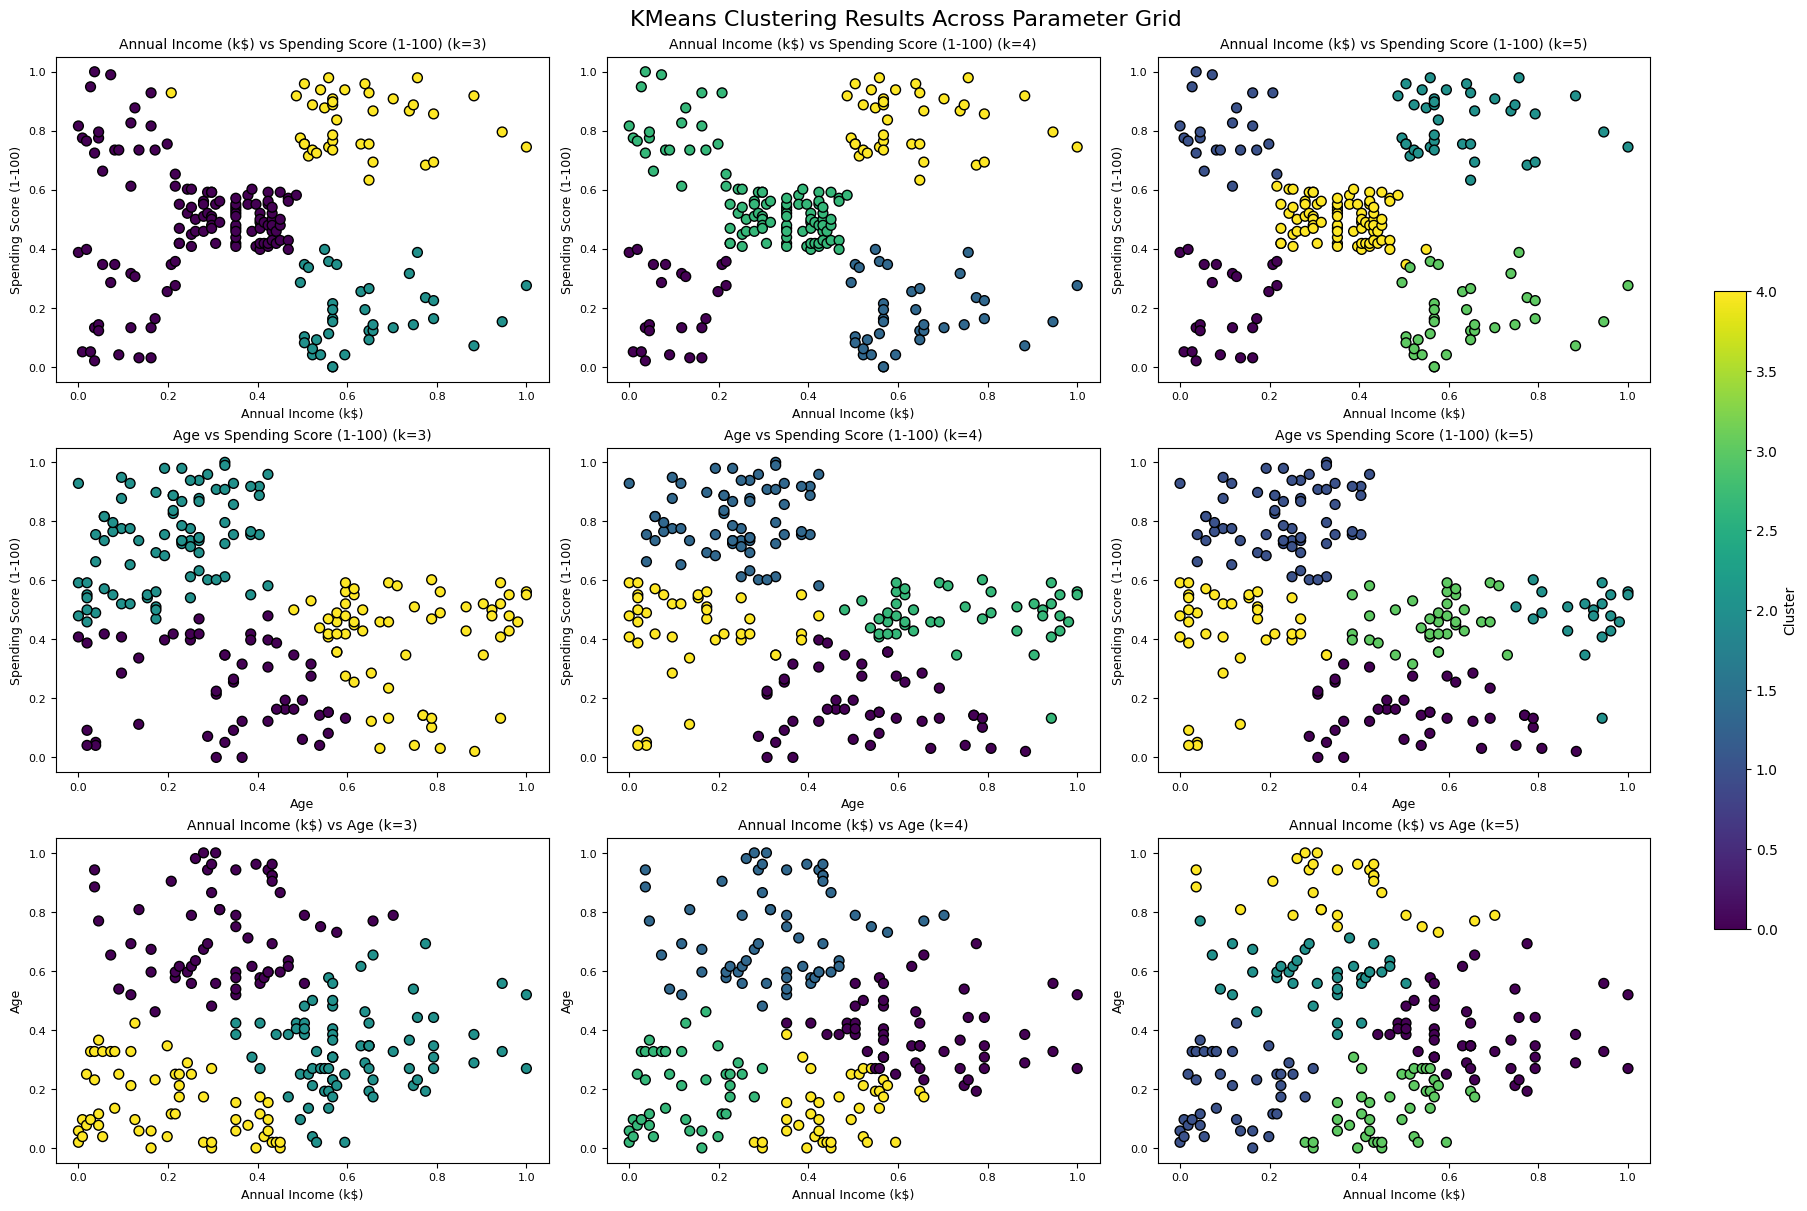

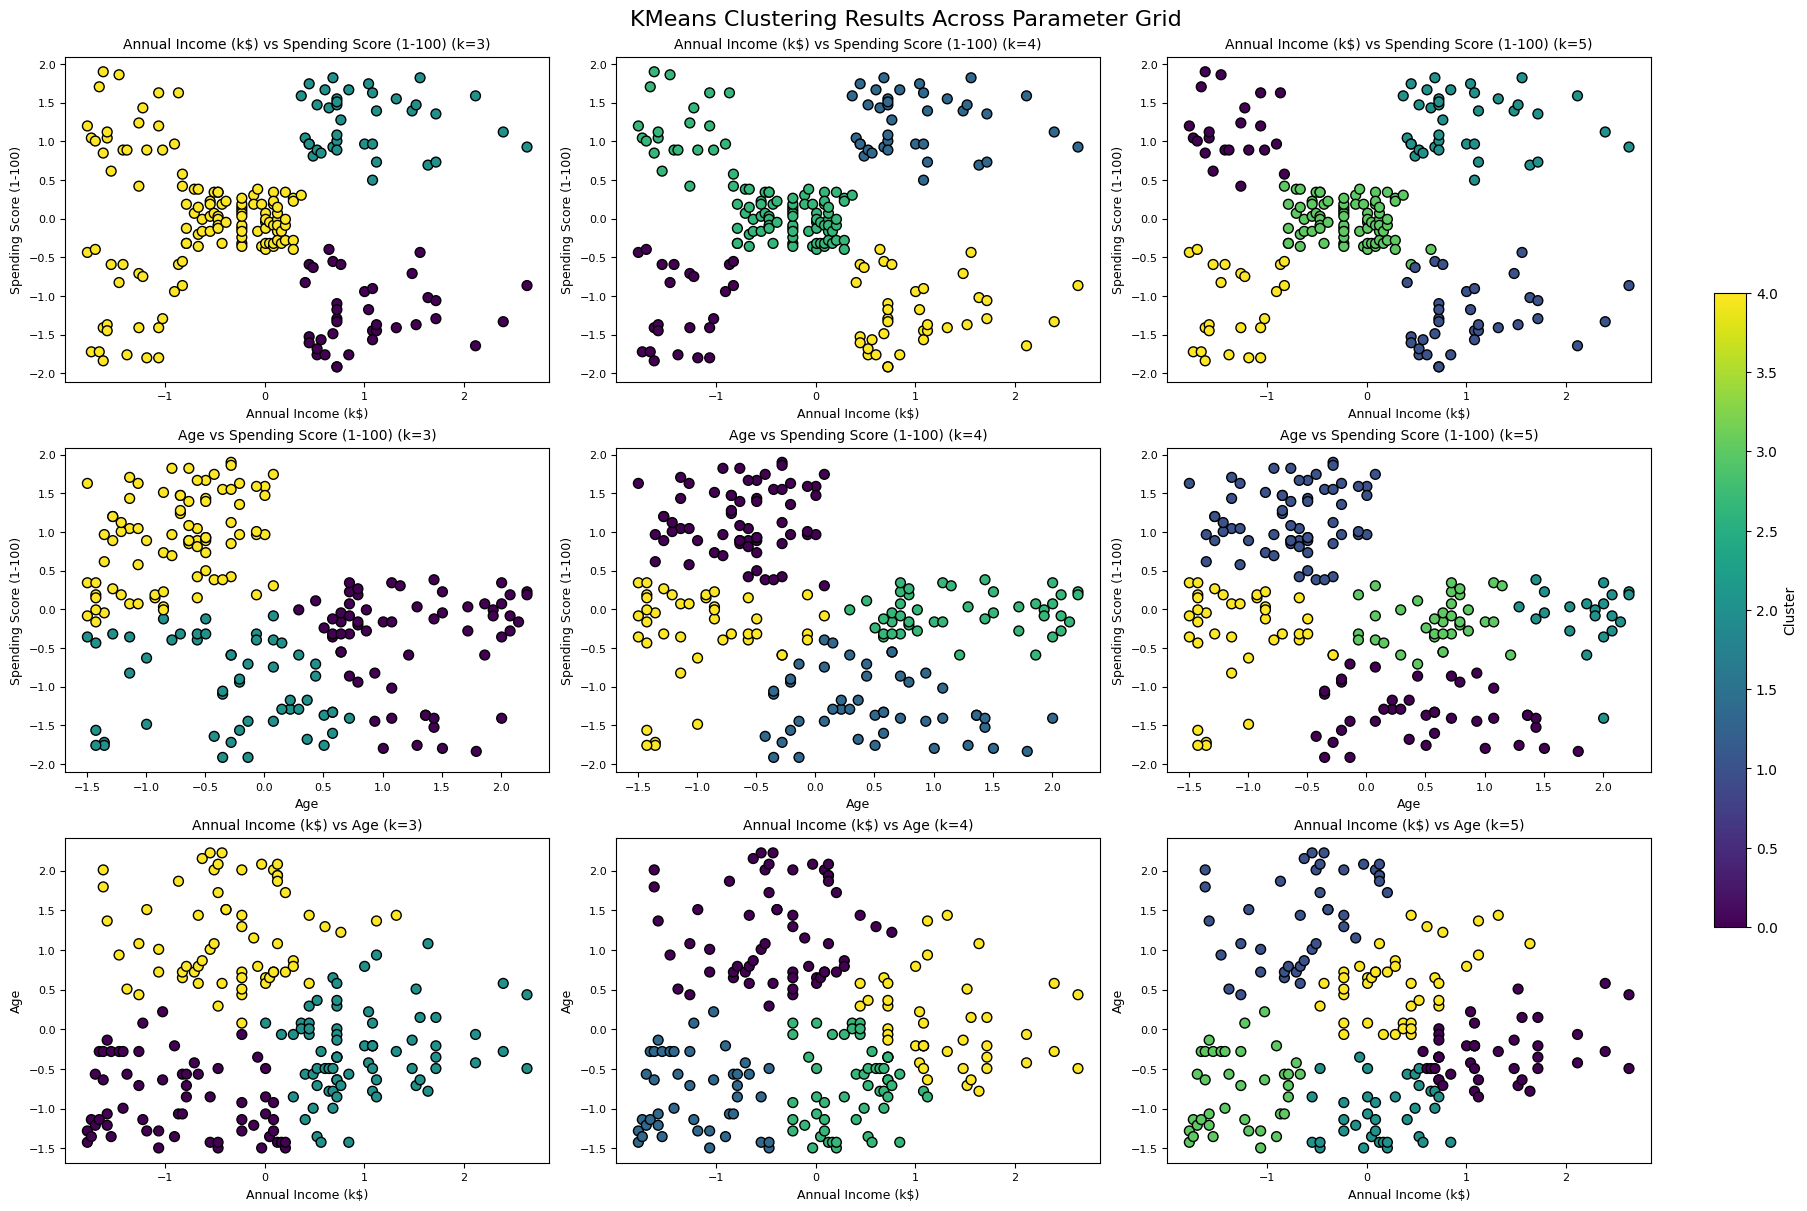

In [420]:
cluster_values = [3, 4, 5]
feature_pairs = [
    ['Annual Income (k$)', 'Spending Score (1-100)'],
    ['Age', 'Spending Score (1-100)'],
    ['Annual Income (k$)', 'Age']
]

kmeans_clustering(data_minmax, numerical_features=['Annual Income (k$)', 'Spending Score (1-100)'],
                  cluster_values=[3, 4, 5], feature_pairs=feature_pairs)

kmeans_clustering(data_standard, numerical_features=['Annual Income (k$)', 'Spending Score (1-100)'],
                  cluster_values=[3, 4, 5], feature_pairs=feature_pairs)


### 2.1.2 DBSCAN clustering

  Tried to get the correct value of eps using KNN, but the results of the clustering didnt get affected anyway.

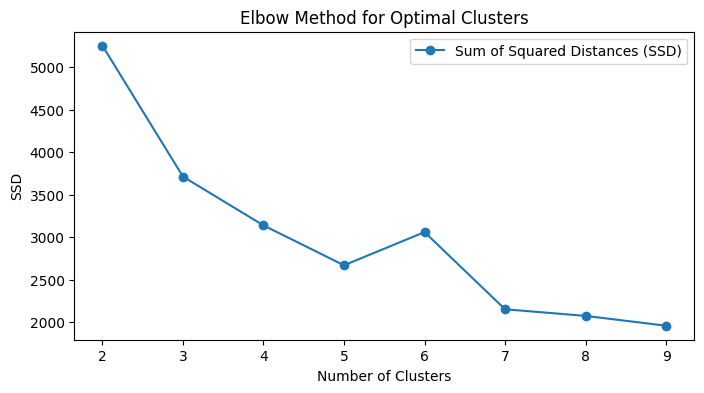

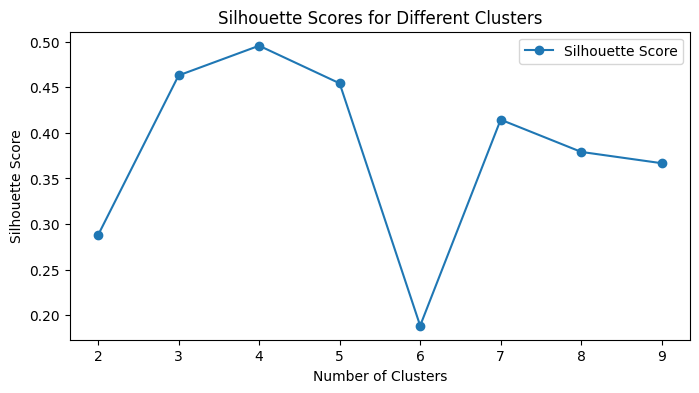

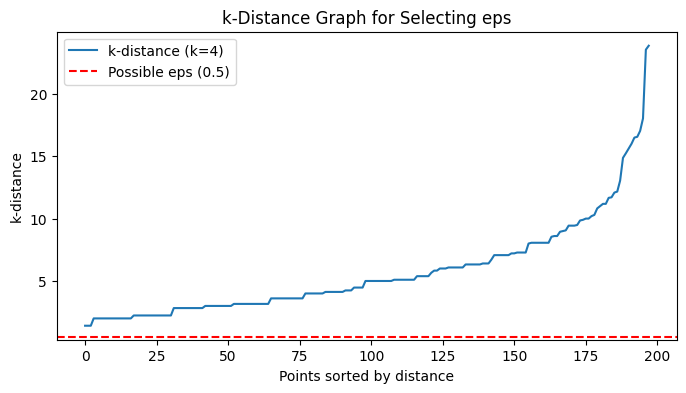

In [422]:
X = data_cleaned[['Annual Income (k$)', 'Spending Score (1-100)']]

ssd = []
silhouette_scores = []
n_clusters_range = range(2, 10)  # Possible number of clusters

for n_clusters in n_clusters_range:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    kmedoids_labels = kmedoids.fit_predict(X)
    ssd.append(kmedoids.inertia_)

    # Silhouette score
    if len(set(kmedoids_labels)) > 1:  # Valid clusters
        silhouette_scores.append(silhouette_score(X, kmedoids_labels))
    else:
        silhouette_scores.append(None)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, ssd, marker='o', label='Sum of Squared Distances (SSD)')
plt.xlabel('Number of Clusters')
plt.ylabel('SSD')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Clusters')
plt.legend()
plt.show()

from sklearn.neighbors import NearestNeighbors

# Compute the k-nearest neighbors
k = 4  # Choose min_samples
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# Sort distances for the k-distance plot
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(8, 4))
plt.plot(distances, label="k-distance (k=4)")
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('k-Distance Graph for Selecting eps')
plt.axhline(y=0.5, color='r', linestyle='--', label='Possible eps (0.5)')
plt.legend()
plt.show()

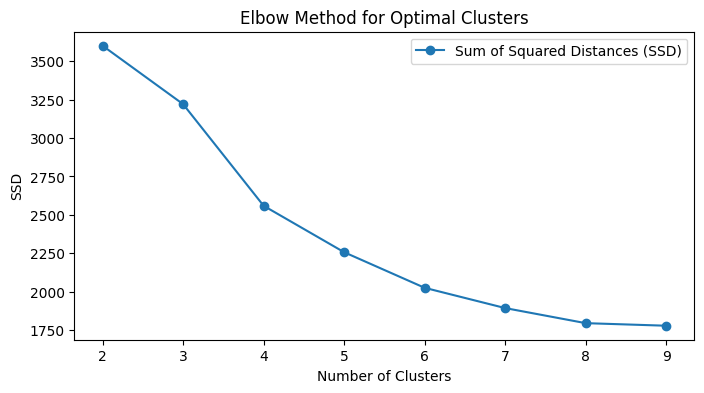

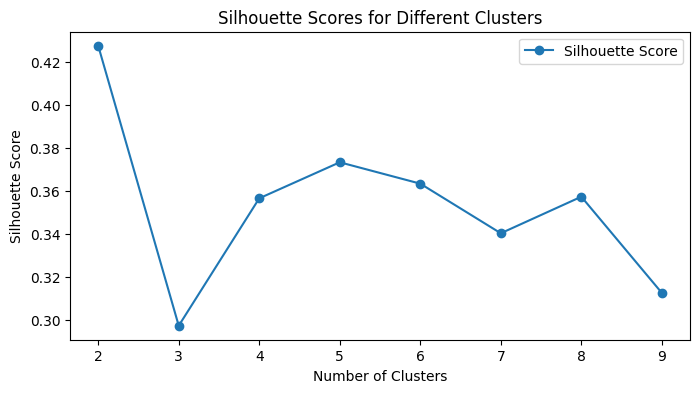

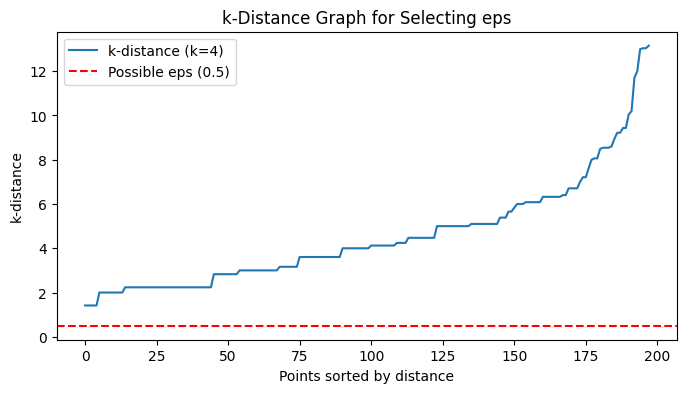

In [447]:
X = data_cleaned[['Annual Income (k$)', 'Age']]

ssd = []
silhouette_scores = []
n_clusters_range = range(2, 10)  # Possible number of clusters

for n_clusters in n_clusters_range:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    kmedoids_labels = kmedoids.fit_predict(X)
    ssd.append(kmedoids.inertia_)

    # Silhouette score
    if len(set(kmedoids_labels)) > 1:  # Valid clusters
        silhouette_scores.append(silhouette_score(X, kmedoids_labels))
    else:
        silhouette_scores.append(None)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, ssd, marker='o', label='Sum of Squared Distances (SSD)')
plt.xlabel('Number of Clusters')
plt.ylabel('SSD')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Clusters')
plt.legend()
plt.show()

from sklearn.neighbors import NearestNeighbors

# Compute the k-nearest neighbors
k = 4  # Choose min_samples
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# Sort distances for the k-distance plot
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(8, 4))
plt.plot(distances, label="k-distance (k=4)")
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('k-Distance Graph for Selecting eps')
plt.axhline(y=0.5, color='r', linestyle='--', label='Possible eps (0.5)')
plt.legend()
plt.show()

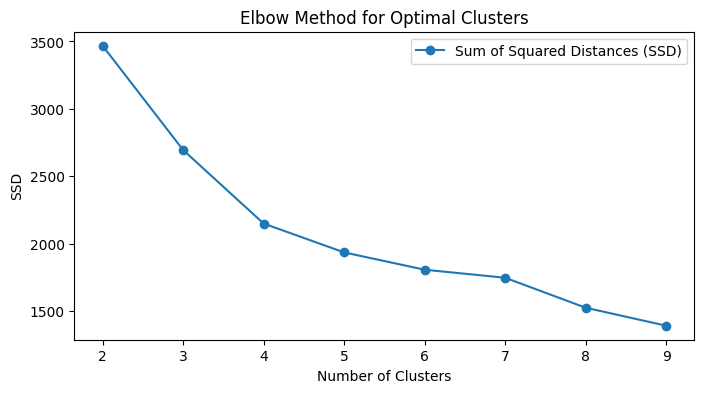

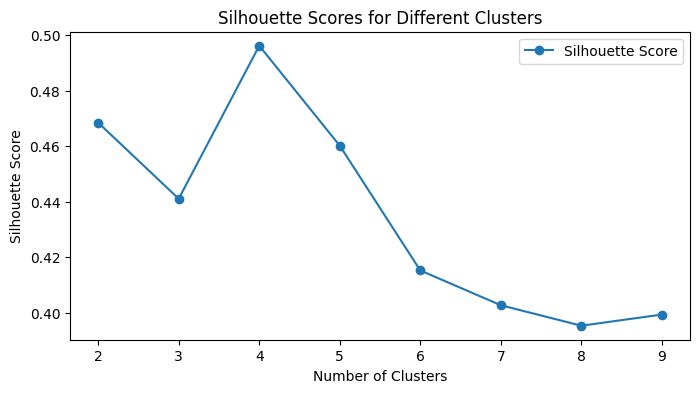

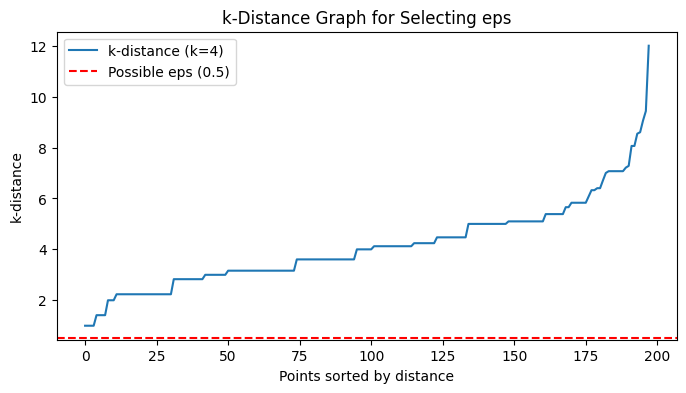

In [448]:
X = data_cleaned[['Age', 'Spending Score (1-100)']]

ssd = []
silhouette_scores = []
n_clusters_range = range(2, 10)  # Possible number of clusters

for n_clusters in n_clusters_range:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    kmedoids_labels = kmedoids.fit_predict(X)
    ssd.append(kmedoids.inertia_)

    # Silhouette score
    if len(set(kmedoids_labels)) > 1:  # Valid clusters
        silhouette_scores.append(silhouette_score(X, kmedoids_labels))
    else:
        silhouette_scores.append(None)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, ssd, marker='o', label='Sum of Squared Distances (SSD)')
plt.xlabel('Number of Clusters')
plt.ylabel('SSD')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Clusters')
plt.legend()
plt.show()

from sklearn.neighbors import NearestNeighbors

# Compute the k-nearest neighbors
k = 4  # Choose min_samples
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# Sort distances for the k-distance plot
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(8, 4))
plt.plot(distances, label="k-distance (k=4)")
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('k-Distance Graph for Selecting eps')
plt.axhline(y=0.5, color='r', linestyle='--', label='Possible eps (0.5)')
plt.legend()
plt.show()

In [423]:
data_standard = data_cleaned.copy()
data_minmax = data_cleaned.copy()

# Select numerical features to scale
numerical_features = ['Annual Income (k$)', 'Spending Score (1-100)', 'Age']

# Apply StandardScaler
scaler_standard = StandardScaler()
data_standard[numerical_features] = scaler_standard.fit_transform(data_standard[numerical_features])

# Apply MinMaxScaler
scaler_minmax = MinMaxScaler()
data_minmax[numerical_features] = scaler_minmax.fit_transform(data_minmax[numerical_features])

In [424]:
def dbscan_clustering(data, numerical_features, eps_values, min_samples_values):
    X = data[numerical_features]
    # Create a grid of subplots
    fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(20, 12))
    fig.suptitle('DBSCAN Clustering Results Across Parameter Grid', fontsize=16, y=1.02)
    # Looping over eps and min_samples combinations
    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(X)
            data['DBSCAN_Labels'] = dbscan_labels
            # Handle empty clusters (all -1 labels)
            unique_labels = np.unique(dbscan_labels)
            if len(unique_labels) == 1 and unique_labels[0] == -1:
                cluster_title = f"No clusters found (eps={eps}, min_samples={min_samples})"
            else:
                cluster_title = f'eps={eps}, min_samples={min_samples}'

            # Plot
            ax = axes[i, j]
            scatter = ax.scatter(
                data['Annual Income (k$)'],
                data['Spending Score (1-100)'],
                c=data['DBSCAN_Labels'],
                cmap='plasma',
                s=50,
                edgecolor='k'
            )
            ax.set_title(cluster_title, fontsize=10)
            ax.set_xlabel('Annual Income', fontsize=9)
            ax.set_ylabel('Spending Score', fontsize=9)
            ax.tick_params(axis='both', labelsize=8)
    # Add a shared colorbar
    fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04, label='Cluster')
    plt.show()

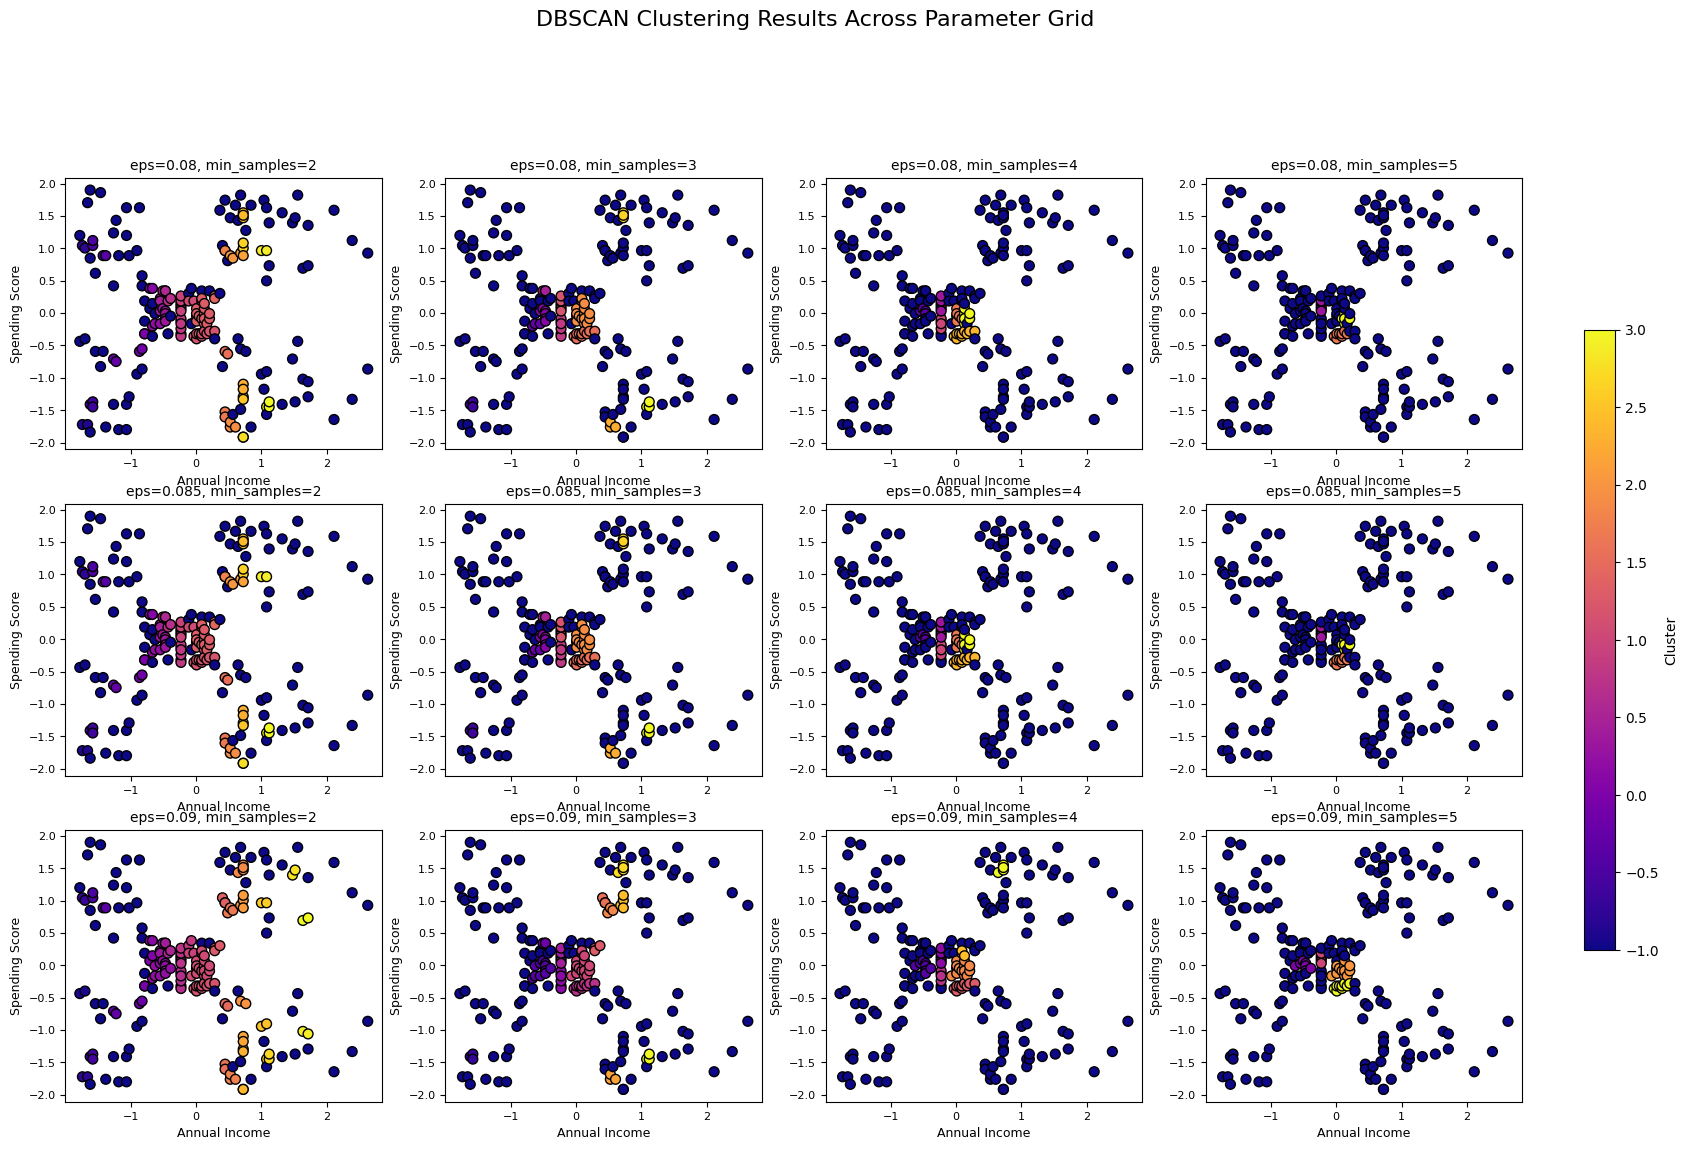

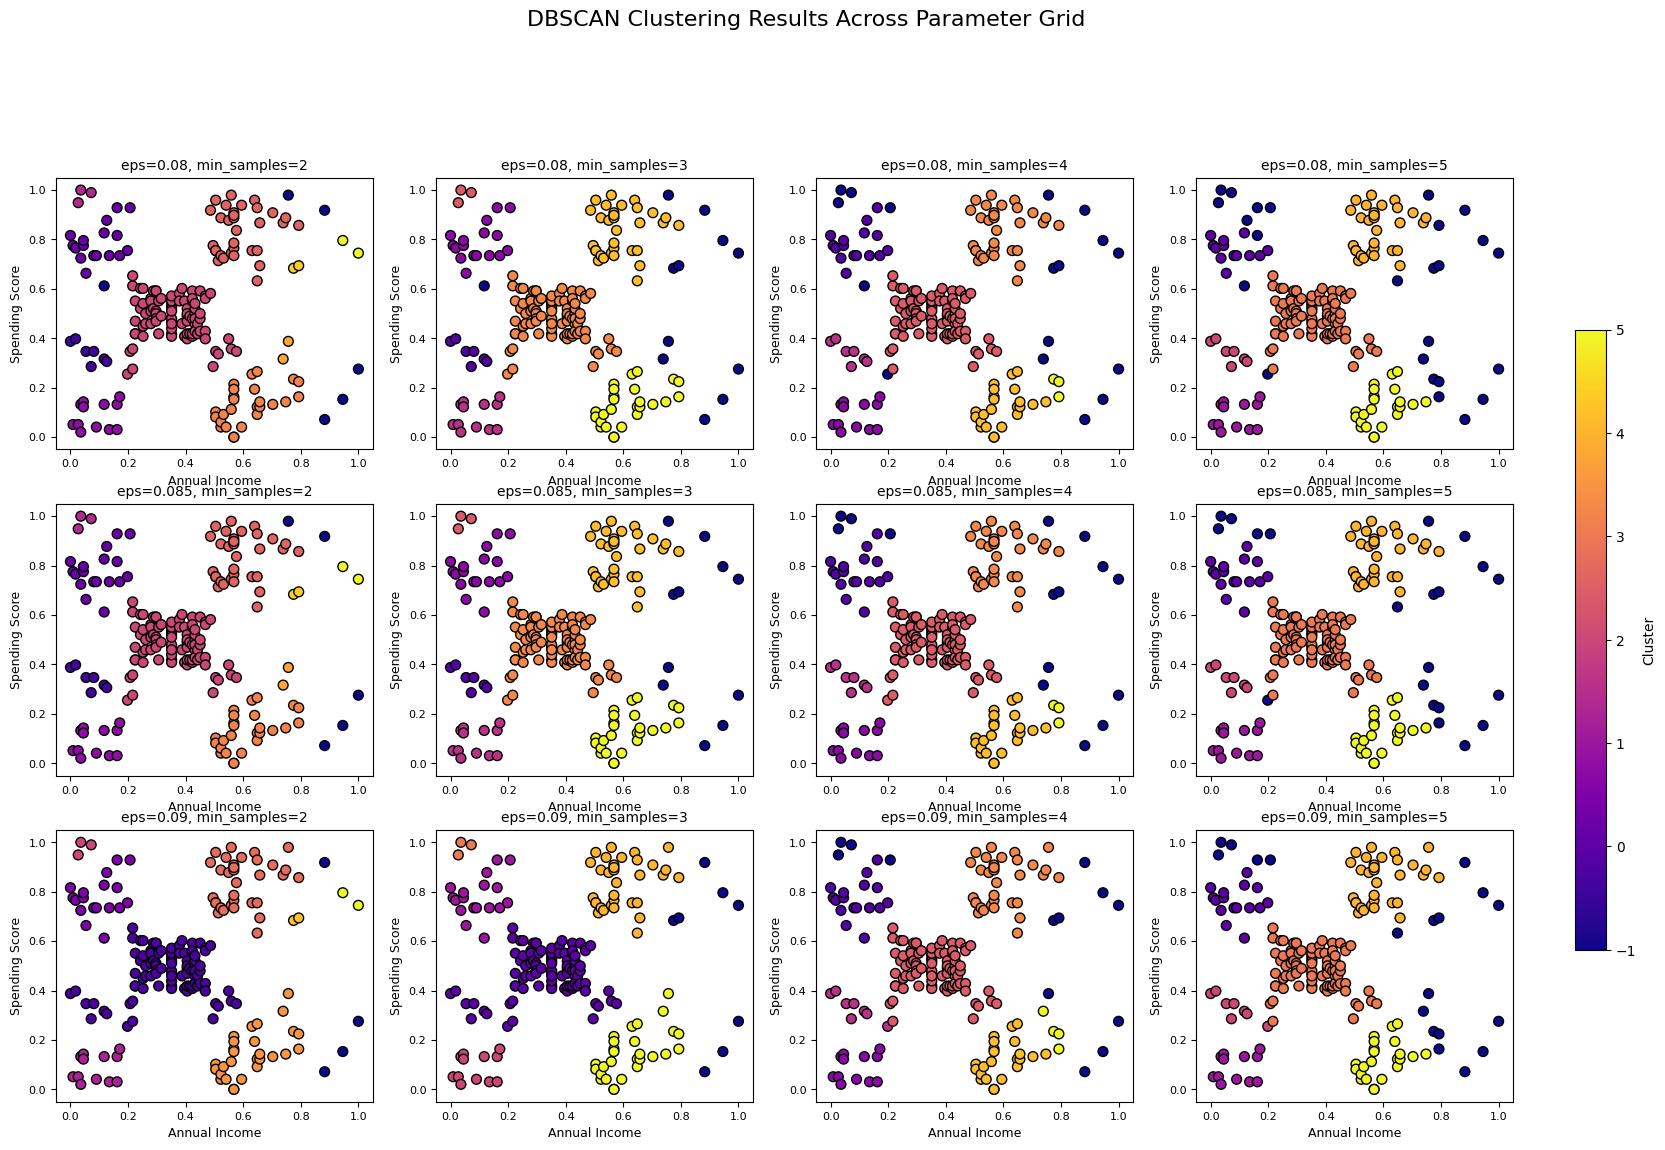

In [425]:
dbscan_clustering(data_standard, numerical_features=['Annual Income (k$)', 'Spending Score (1-100)'],
                  eps_values=[ 0.08, 0.085, 0.09], min_samples_values=[2, 3, 4, 5])



dbscan_clustering(data_minmax, numerical_features=['Annual Income (k$)', 'Spending Score (1-100)'],
                  eps_values=[ 0.08, 0.085, 0.09],min_samples_values = [2, 3, 4, 5])





#### **Observations:**

* **Impact of `eps`:**
    * **Decreasing `eps`:** Leads to the formation of more, smaller clusters and an increase in the number of noise points (depicted in dark blue/purple). This is because the neighborhood radius shrinks, requiring points to be closer to form a cluster.
    * **Increasing `eps` :** Results in fewer, larger clusters. Points that were previously considered noise or part of separate clusters are now grouped together.

* **Impact of `min_samples`:**
    * **Increasing `min_samples` :**  Makes it harder for points to be considered core points. This results in a decrease in the number of core points, leading to fewer and more compact clusters. Some points that were part of clusters with lower `min_samples` are now classified as noise.
    * **Decreasing `min_samples`:** Makes it easier for points to be considered core points, potentially leading to the formation of more clusters and the inclusion of more points within existing clusters.

* **Noise Points:** The dark blue/purple points represent noise, meaning they do not belong to any cluster based on the specified parameter combination.


### 2.1.3 Agglomerative clustering

In [426]:
def agglomerative_clustering(data1, data2, numerical_features, n_clusters_list, method):
    X1 = data1[numerical_features]
    X2 = data2[numerical_features]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Two rows: scatterplots & dendrograms

    # Iterate over datasets
    for idx, (X, dataset_label) in enumerate(zip([X1, X2], ['Standardized', 'Min-Max'])):
        for n_clusters in n_clusters_list:
            # Perform clustering
            agg_clust = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
            agg_labels = agg_clust.fit_predict(X)
            data = data1 if idx == 0 else data2
            data['Agg_Clust_Labels'] = agg_labels

            # Plot scatterplot
            axes[idx][0].scatter(
                data[numerical_features[0]],
                data[numerical_features[1]],
                c=data['Agg_Clust_Labels'], cmap='inferno', s=50
            )
            axes[idx][0].set_title(f'{dataset_label} Data: Agglomerative Clustering (n={n_clusters})')
            axes[idx][0].set_xlabel(numerical_features[0])
            axes[idx][0].set_ylabel(numerical_features[1])

            # Generate dendrogram
            linked = linkage(X, method=method)
            dendrogram(
                linked,
                truncate_mode='lastp',
                orientation='top',
                p=50,
                distance_sort='descending',
                show_leaf_counts=True,
                ax=axes[idx][1]
            )
            axes[idx][1].set_title(f'{dataset_label} Data: Dendrogram (Method: {method})')
            axes[idx][1].set_xlabel('Data Points')
            axes[idx][1].set_ylabel('Manhattan Distance')

    plt.tight_layout()
    plt.show()

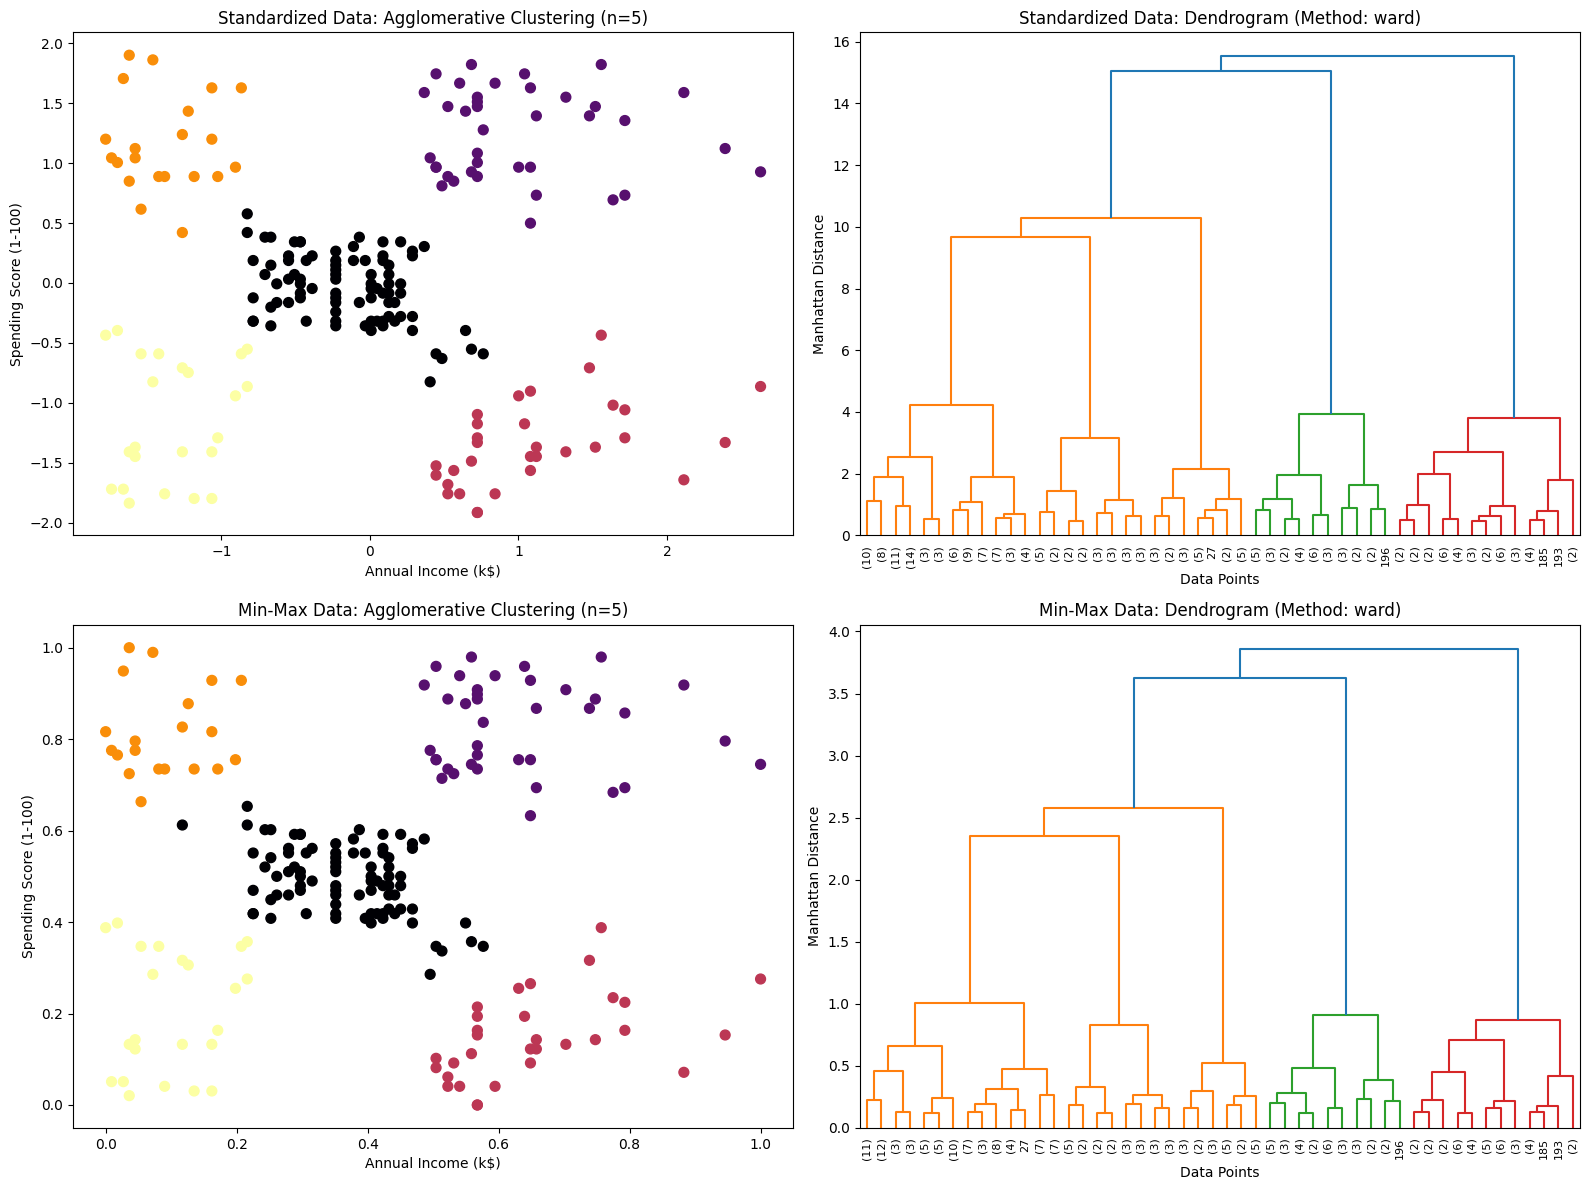

In [427]:
agglomerative_clustering(
    data1=data_standard,
    data2=data_minmax,
    numerical_features=['Annual Income (k$)', 'Spending Score (1-100)'],
    n_clusters_list=[5],
    method='ward'
)


 #### **Observations from Scatter Plots:**

* **Standardized Data:** The clusters appear more evenly distributed and separated in the standardized data plot. This is expected as standardization centers the data around zero and scales it to have unit variance, which can improve the performance of distance-based clustering algorithms.
* **Min-Max Scaled Data:** The clusters in the Min-Max scaled plot also show distinct groupings, but the visual separation between some clusters (e.g., the yellow and orange clusters on the left) seems less pronounced compared to the standardized data. This could be due to the scaling compressing the data into a 0-1 range, potentially reducing the relative distances between certain data points.
* **Cluster Consistency:** Despite the scaling differences, the overall shape and grouping of the clusters seem relatively consistent between the two scaling methods. Both methods identify similar core groups of data points.

#### **Observations from Dendrograms:**

* **Standardized Data Dendrogram:** The dendrogram for the standardized data exhibits clearer branching patterns at higher Euclidean distances. This indicates a more distinct hierarchical structure in the data after standardization. The long vertical lines before merging suggest relatively well-separated initial clusters.
* **Min-Max Scaled Data Dendrogram:** The dendrogram for the Min-Max scaled data shows merges occurring at lower Euclidean distances compared to the standardized data. This suggests that the data points are closer together in the scaled space, which is consistent with the visual observation from the scatter plot. The branching structure is also somewhat less pronounced than in the standardized data dendrogram.


####2.1.3.1 Dendrogram using euclidean distance for Standard and MinMax scaled data

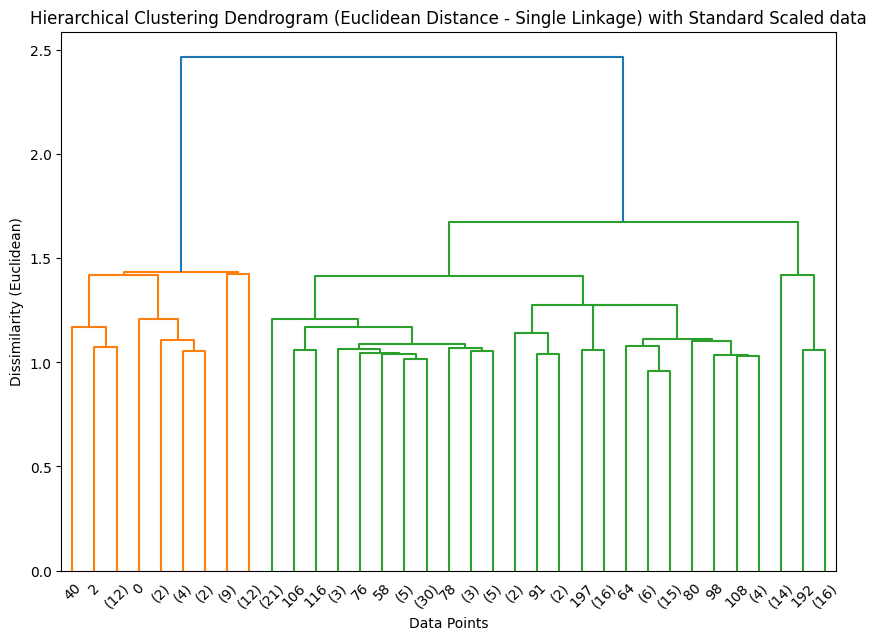

Optimal number of clusters (Euclidean): 3


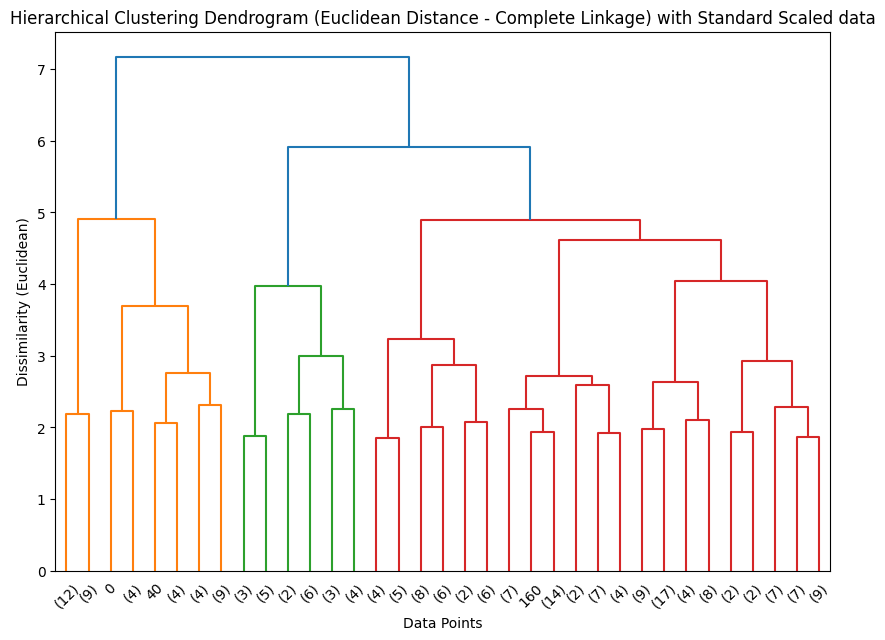

Optimal number of clusters (Euclidean): 3


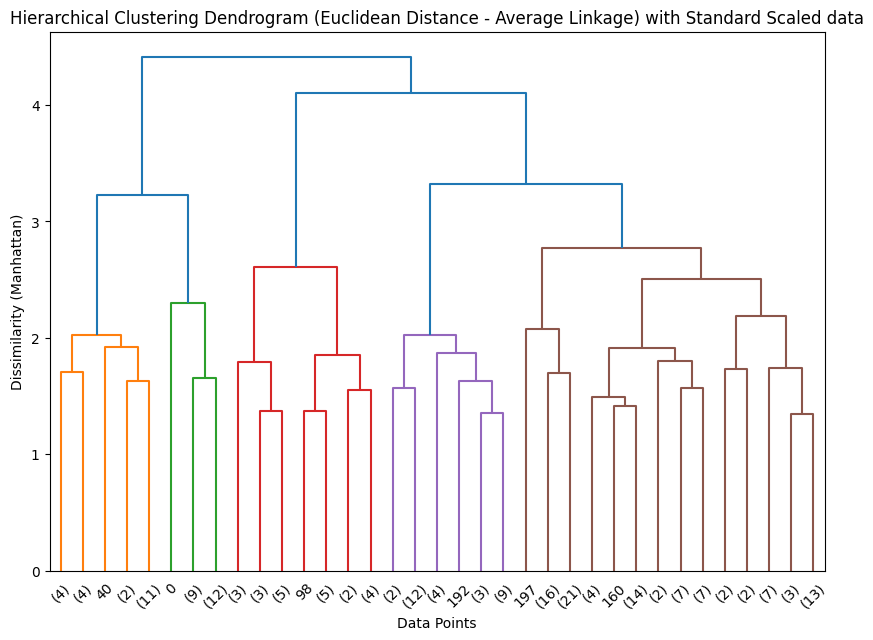

Optimal number of clusters (Manhattan): 3


In [428]:
# Euclidean Distance Dendrogram (using 'single')
single_euclidean = linkage(data_standard, method='single', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(single_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Single Linkage) with Standard Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(single_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")


# Euclidean Distance Dendrogram (using 'complete')
Complete_euclidean = linkage(data_standard, method='complete', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(Complete_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Complete Linkage) with Standard Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(Complete_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")


# Euclidean Distance Dendrogram (using 'average' linkage method)
Average_euclidean = linkage(data_standard, method='average', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(Average_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Average Linkage) with Standard Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_manhattan = fcluster(Average_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_manhattan))}")


**Dendrogram 3: Euclidean Distance - Average Linkage**
*   **Observations:**  We observe roughly 5-6 potential clusters based on the long vertical lines before merging. The cluster sizes appear somewhat balanced.

**Dendrogram 2: Euclidean Distance - Complete Linkage**
*   **Observations:**  Similar to the first dendrogram, around 5-6 potential clusters are visible. However, the cluster formation appears more stepwise, suggesting tighter subgroups within larger clusters. The vertical distances for merges are generally larger than in the average linkage dendrogram.

**Dendrogram 1: Euclidean Distance - Single Linkage**
*   **Observations:** This dendrogram shows a different merging pattern. While we can still identify some initial clusters (like the orange group), the subsequent merges happen at relatively low dissimilarity values.


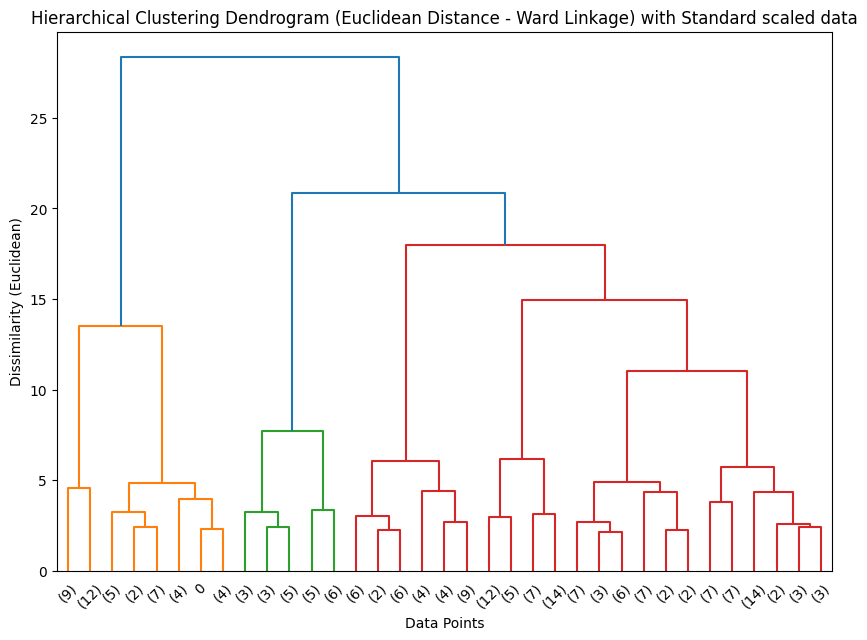

Optimal number of clusters (Euclidean): 3


In [429]:
# Euclidean Distance Dendrogram (using 'ward')
linked_euclidean = linkage(data_standard, method='ward', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(linked_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Ward Linkage) with Standard scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(linked_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")

**Observations:**
*   The dendrogram shows a clear separation into several initial smaller clusters at lower dissimilarity values.
*   There is a noticeable jump in dissimilarity when merging the orange and green clusters with the larger red cluster.
*   The optimal number of clusters, as indicated by a separate evaluation, is 3.

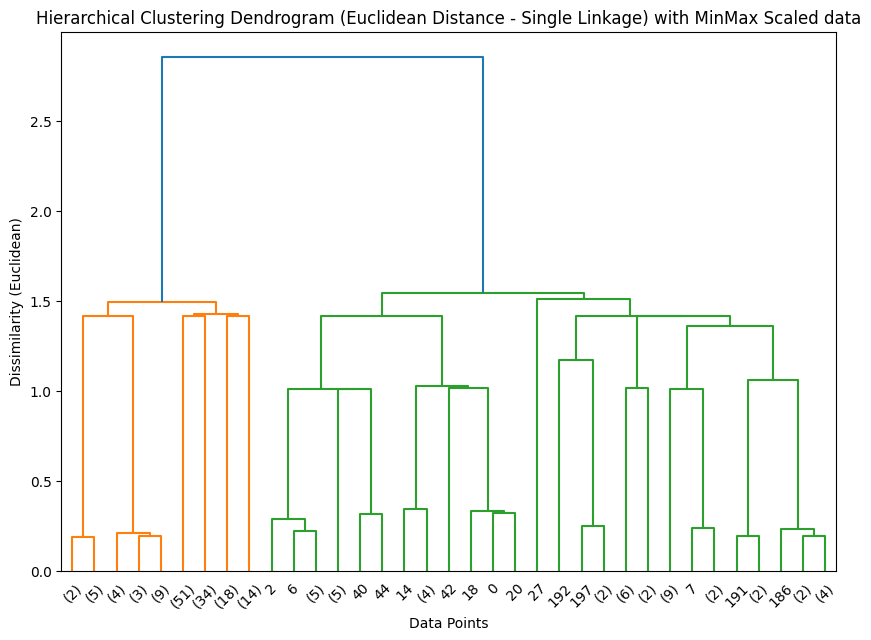

Optimal number of clusters (Euclidean): 3


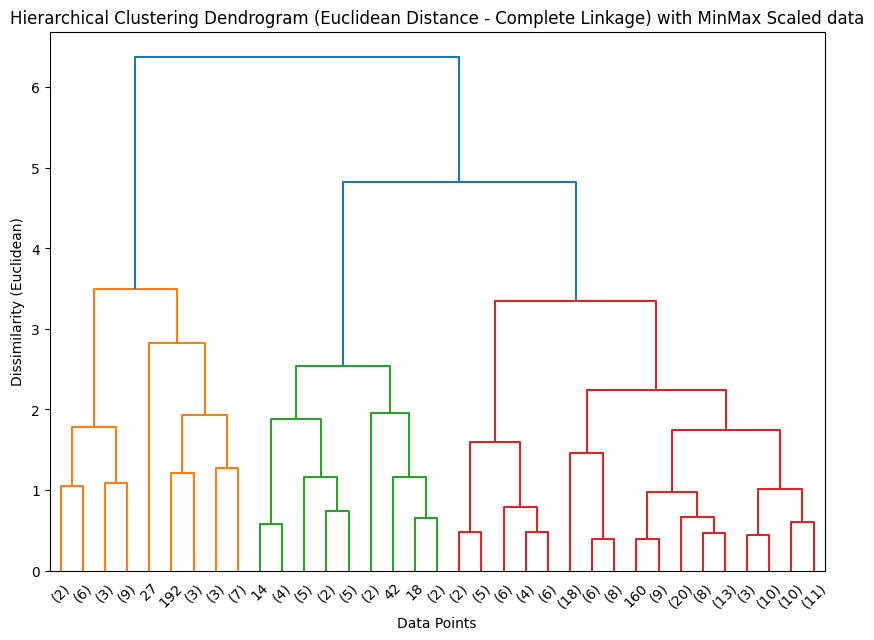

Optimal number of clusters (Euclidean): 3


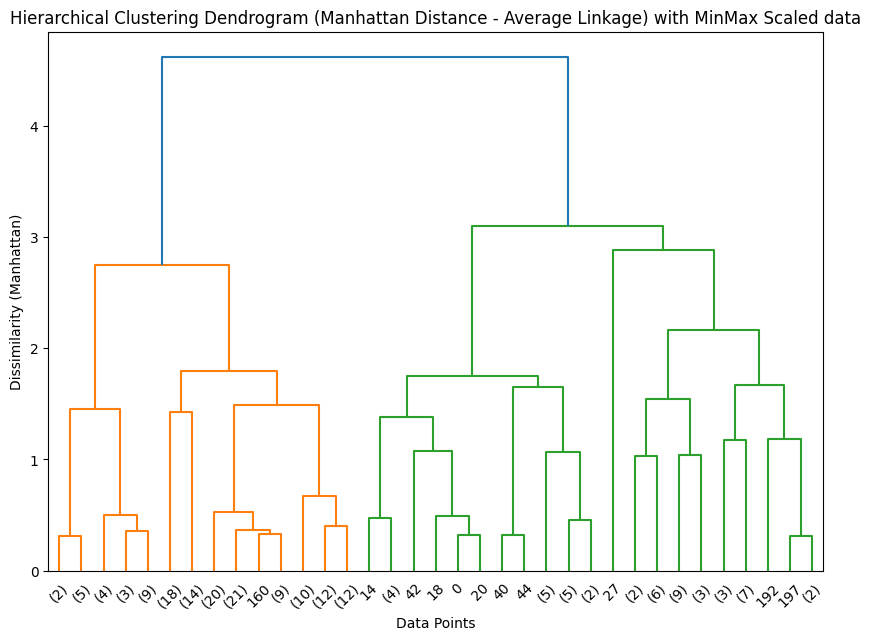

Optimal number of clusters (Manhattan): 3


In [430]:
# Euclidean Distance Dendrogram (using 'single')
single_euclidean = linkage(data_minmax, method='single', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(single_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Single Linkage) with MinMax Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(single_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")


# Euclidean Distance Dendrogram (using 'complete')
Complete_euclidean = linkage(data_minmax, method='complete', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(Complete_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Complete Linkage) with MinMax Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(Complete_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")


# Euclidean Distance Dendrogram (using 'average' linkage method)
Average_euclidean = linkage(data_minmax, method='average', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(Average_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Average Linkage) with MinMax Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan
optimal_clusters_manhattan = fcluster(Average_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_manhattan))}")


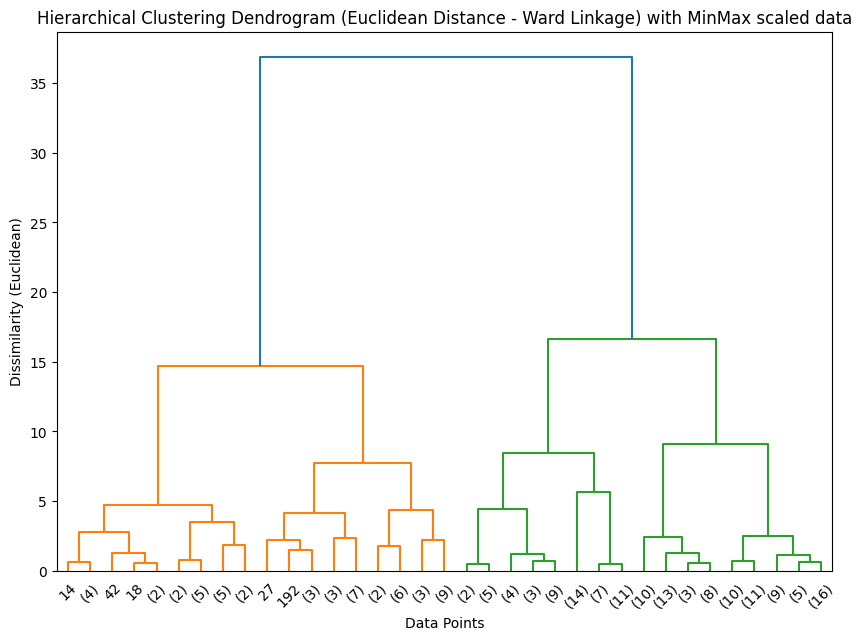

Optimal number of clusters (Euclidean): 3


In [431]:
# Euclidean Distance Dendrogram (using 'ward')
linked_euclidean = linkage(data_minmax, method='ward', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(linked_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Ward Linkage) with MinMax scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(linked_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")

####2.1.3.2 Dendrogram using Manhattan distance for Standard and MinMax scaled data

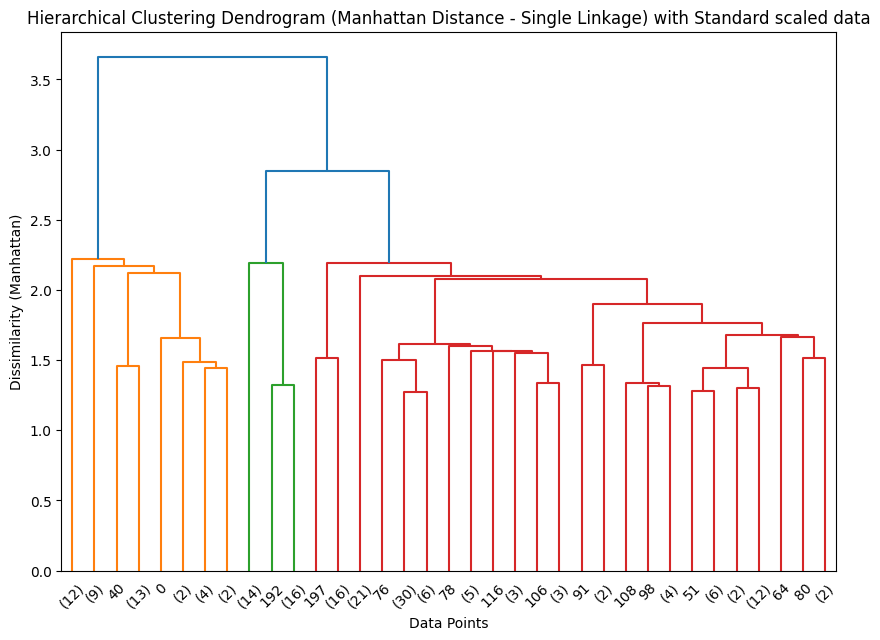

Optimal number of clusters (Manhattan - Single Linkage): 3


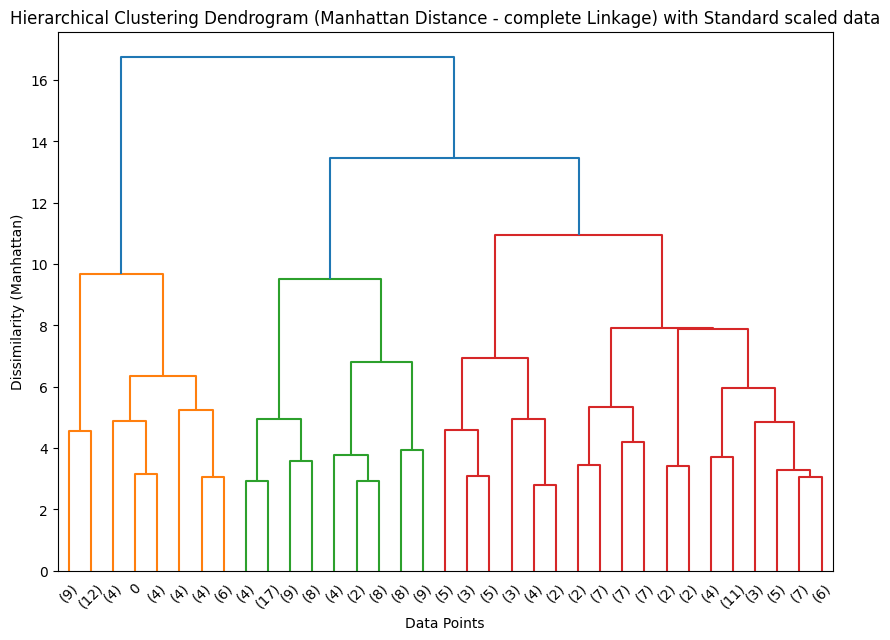

Optimal number of clusters (Manhattan - Single Linkage): 3


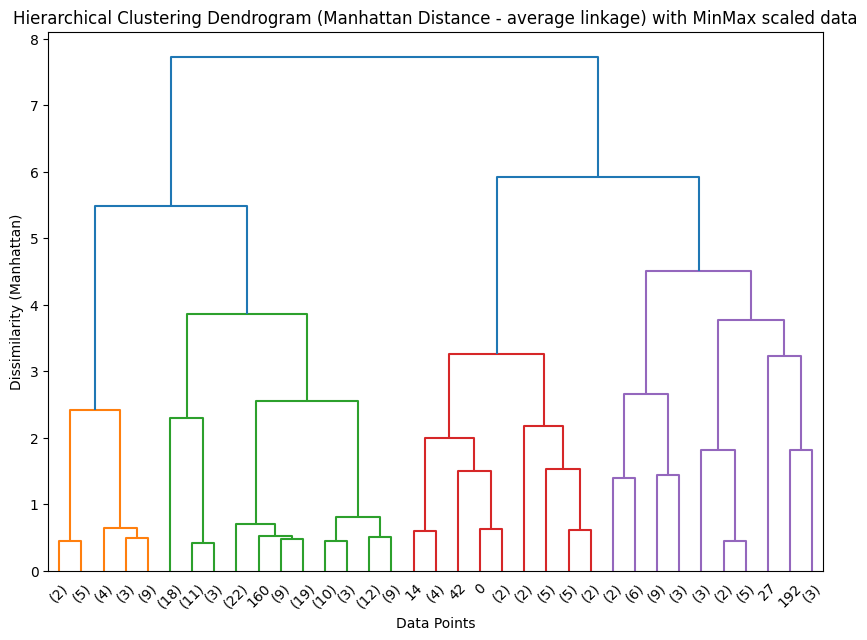

Optimal number of clusters (Manhattan): 3


In [432]:
# Manhattan Distance Dendrogram (using 'single' linkage method)
linked_manhattan_single = linkage(data_standard, method='single', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(linked_manhattan_single, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Single Linkage) with Standard scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan (Single Linkage)
optimal_clusters_manhattan_single = fcluster(linked_manhattan_single, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan - Single Linkage): {len(set(optimal_clusters_manhattan_single))}")


# Manhattan Distance Dendrogram (using 'complete' linkage method)
linked_manhattan_complete = linkage(data_standard, method='complete', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(linked_manhattan_complete, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - complete Linkage) with Standard scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan (Complete Linkage)
optimal_clusters_manhattan_single = fcluster(linked_manhattan_single, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan - Single Linkage): {len(set(optimal_clusters_manhattan_single))}")


# Manhattan Distance Dendrogram (using 'average' linkage method)
average_manhattan = linkage(data_minmax, method='average', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(average_manhattan, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - average linkage) with MinMax scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan
optimal_clusters_manhattan = fcluster(average_manhattan, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_manhattan))}")


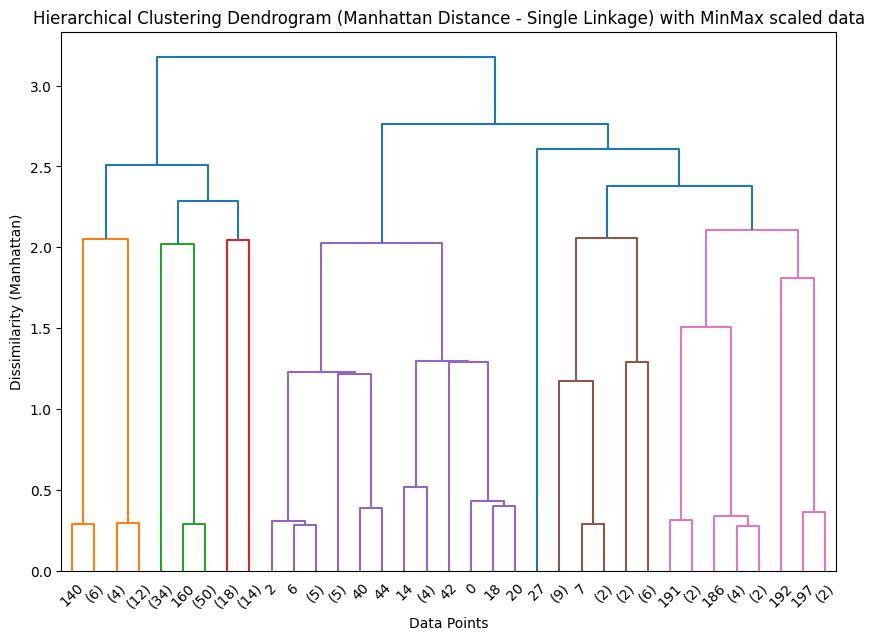

Optimal number of clusters (Manhattan): 3


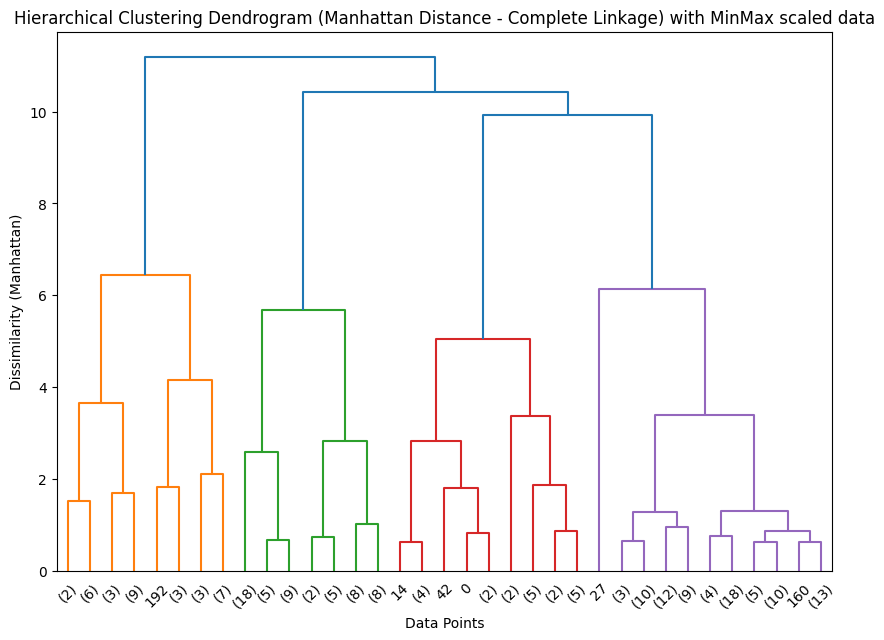

Optimal number of clusters (Manhattan): 3


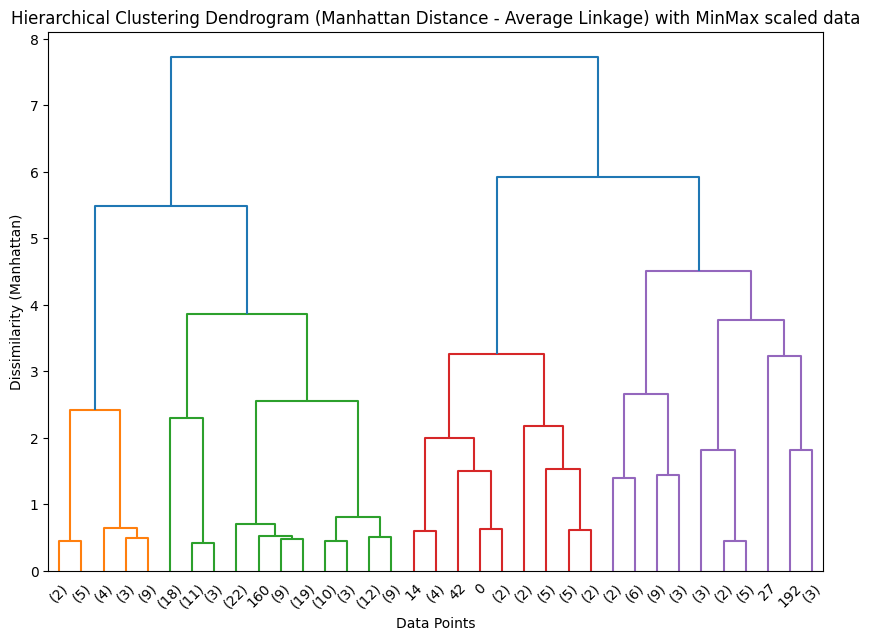

Optimal number of clusters (Manhattan): 3


In [433]:
# Manhattan Distance Dendrogram (using 'single')
single_Manhattan = linkage(data_minmax, method='single', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(single_Manhattan, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Single Linkage) with MinMax scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan
optimal_clusters_Manhattan = fcluster(single_Manhattan, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_Manhattan))}")


# Manhattan Distance Dendrogram (using 'complete')
Complete_Manhattan = linkage(data_minmax, method='complete', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(Complete_Manhattan, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Complete Linkage) with MinMax scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan
optimal_clusters_Manhattan = fcluster(Complete_Manhattan, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_Manhattan))}")


# Manhattan Distance Dendrogram (using 'average' linkage method)
Average_Manhattan = linkage(data_minmax, method='average', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(Average_Manhattan, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Average Linkage) with MinMax scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan
optimal_clusters_manhattan = fcluster(Average_Manhattan, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_manhattan))}")


**Inferences:**

*   Single linkage with Manhattan distance, similar to Euclidean distance, tends to produce less clearly defined clusters due to the chaining effect.
*   Complete linkage with Manhattan distance provides a more structured clustering compared to single linkage, suggesting better separation between groups.
*   The choice of scaling method (Standard vs. MinMax) impacts the magnitude of the dissimilarity values but may not drastically alter the overall hierarchical structure when using average or complete linkage.
*   The consistent observation of chaining with single linkage across both distance metrics and scaling methods highlights the limitations of this linkage method for this dataset.

### 2.1.4 K-Medoids clustering

In [434]:

def kmedoids_clustering(data, numerical_features, cluster_values, feature_pairs, random_state=42):
    # Create a grid of subplots
    fig, axes = plt.subplots(len(feature_pairs), len(cluster_values), figsize=(18, 12), constrained_layout=True)
    fig.suptitle('K-Medoids Clustering Results Across Parameter Grid', fontsize=16)

    # Loop through feature pairs and cluster values
    for i, pair in enumerate(feature_pairs):
        for j, n_clusters in enumerate(cluster_values):
            # Initialize K-Medoids with the specified number of clusters
            kmedoids = KMedoids(n_clusters=n_clusters, random_state=random_state)
            data['KMedoids_Labels'] = kmedoids.fit_predict(data[pair])

            # Plot on the corresponding subplot
            ax = axes[i, j]
            scatter = ax.scatter(
                data[pair[0]],
                data[pair[1]],
                c=data['KMedoids_Labels'],
                cmap='viridis',
                s=50,
                edgecolor='k'
            )
            ax.set_title(f'{pair[0]} vs {pair[1]} (k={n_clusters})', fontsize=10)
            ax.set_xlabel(pair[0], fontsize=9)
            ax.set_ylabel(pair[1], fontsize=9)
            ax.tick_params(axis='both', labelsize=8)

            # Compute Silhouette Score for the current clustering
            silhouette_avg = silhouette_score(data[pair], data['KMedoids_Labels'])
            ax.text(0.95, 0.05, f'Silhouette: {silhouette_avg:.2f}', transform=ax.transAxes, fontsize=8,
                    verticalalignment='bottom', horizontalalignment='right', color='blue')

    # Add a shared colorbar to the figure
    fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04, label='Cluster')

    # Display the plot
    plt.show()


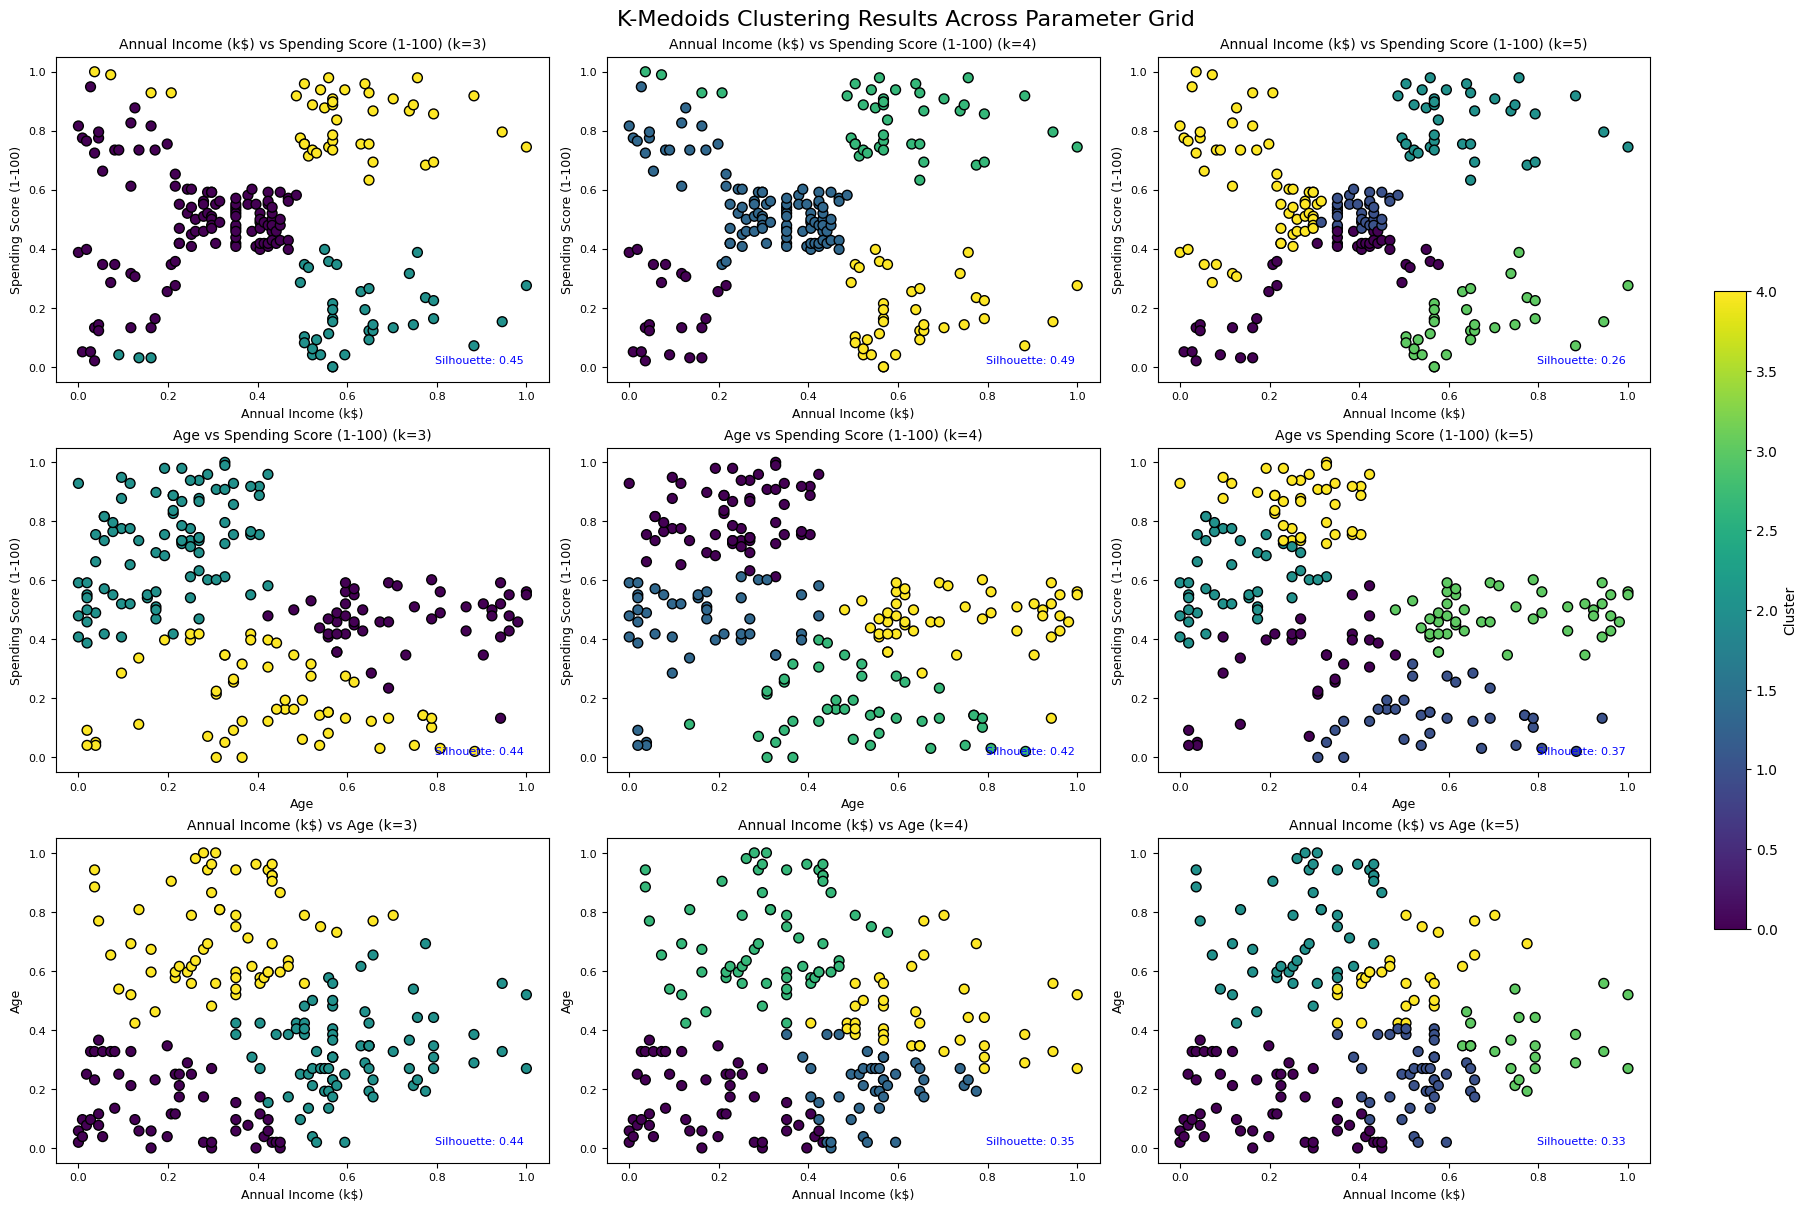

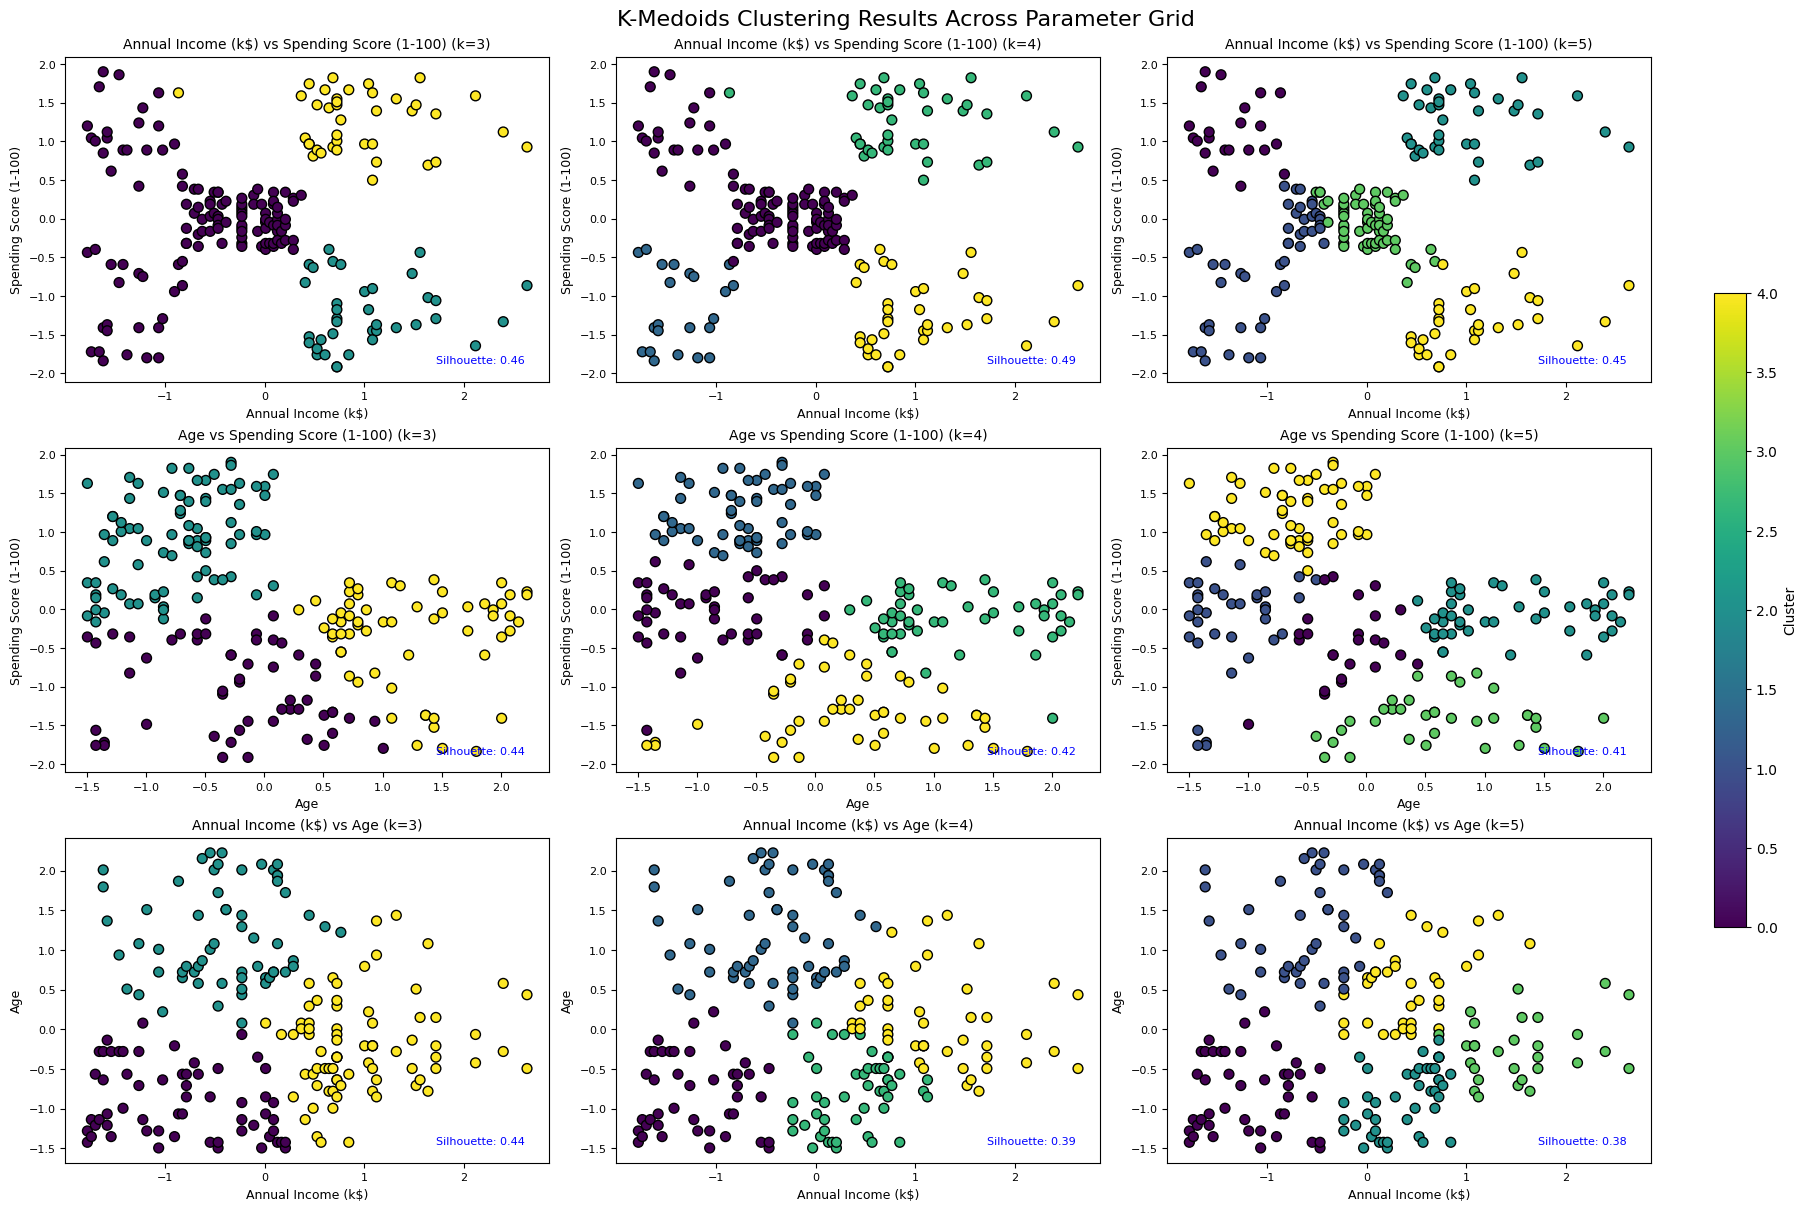

In [435]:
cluster_values = [3, 4, 5]
feature_pairs = [
    ['Annual Income (k$)', 'Spending Score (1-100)'],
    ['Age', 'Spending Score (1-100)'],
    ['Annual Income (k$)', 'Age']
]

# Assuming `data_minmax` and `data_standard` are the datasets
kmedoids_clustering(data_minmax, numerical_features=['Annual Income (k$)', 'Spending Score (1-100)'],
                    cluster_values=cluster_values, feature_pairs=feature_pairs)

kmedoids_clustering(data_standard, numerical_features=['Annual Income (k$)', 'Spending Score (1-100)'],
                    cluster_values=cluster_values, feature_pairs=feature_pairs)



#### Observations and result
-
-
-

### 2.1.5 Gaussian Mixture Model

  this will be our model from outside the learnig scope, GMM is a more flexible alternative to algorithms like K-Means, especially when clusters are not spherical or when the dataset has varying densities, but in our dataset, there probably wont be much difference.


In [436]:
def gmm_clustering(data, numerical_features, n_components_values, covariance_type_values):
    X = data[numerical_features]

    # Create a grid of subplots
    fig, axes = plt.subplots(len(n_components_values), len(covariance_type_values), figsize=(20, 12))
    fig.suptitle('Gaussian Mixture Model Clustering Results Across Parameter Grid', fontsize=16, y=1.02)

    # Looping over n_components and covariance_type combinations
    for i, n_components in enumerate(n_components_values):
        for j, covariance_type in enumerate(covariance_type_values):
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
            gmm_labels = gmm.fit_predict(X)
            data['GMM_Labels'] = gmm_labels

            # Handle empty clusters (if all points are assigned to the same component)
            unique_labels = np.unique(gmm_labels)
            if len(unique_labels) == 1:
                cluster_title = f"Single cluster (n_components={n_components}, covariance={covariance_type})"
            else:
                cluster_title = f'n_components={n_components}, covariance={covariance_type}'

            # Plot
            ax = axes[i, j]
            scatter = ax.scatter(
                data[numerical_features[0]],
                data[numerical_features[1]],
                c=data['GMM_Labels'],
                cmap='viridis',
                s=50,
                edgecolor='k'
            )
            ax.set_title(cluster_title, fontsize=10)
            ax.set_xlabel(numerical_features[0], fontsize=9)
            ax.set_ylabel(numerical_features[1], fontsize=9)
            ax.tick_params(axis='both', labelsize=8)

    # Add a shared colorbar
    fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04, label='Cluster')
    plt.show()

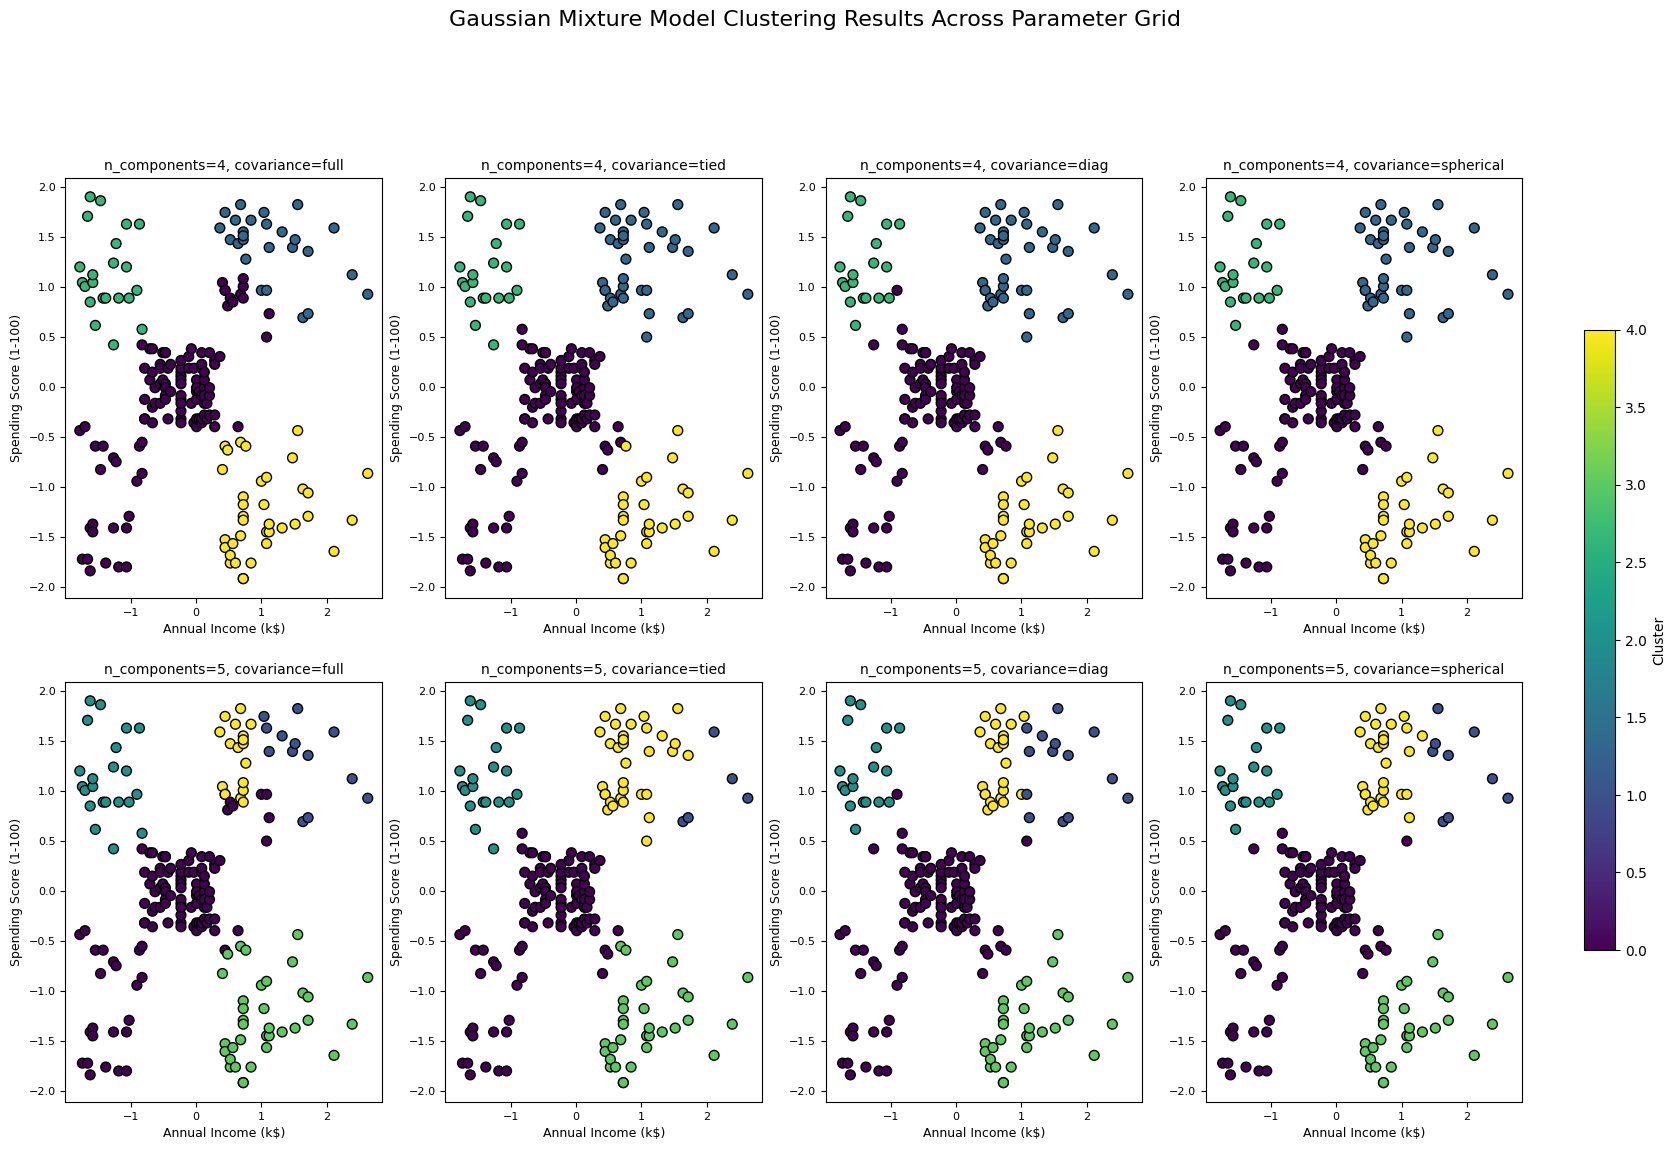

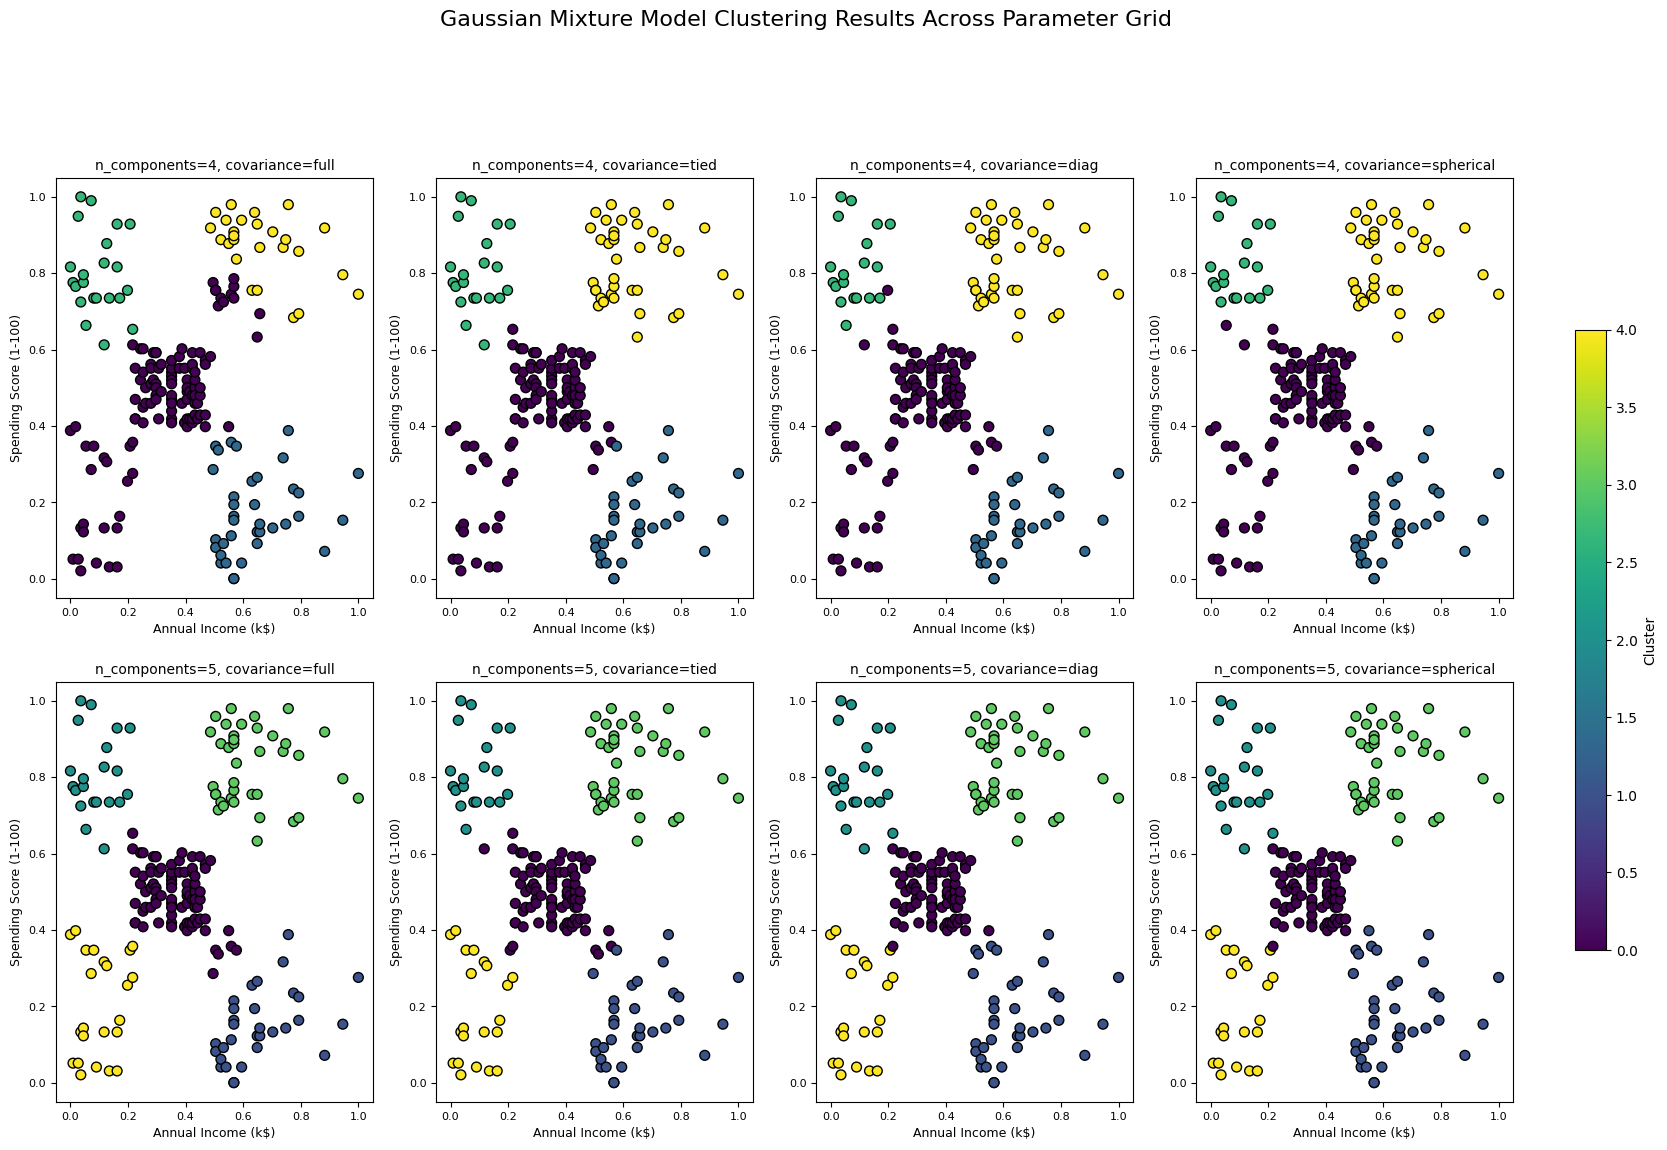

In [437]:
gmm_clustering(data_standard, numerical_features=['Annual Income (k$)', 'Spending Score (1-100)'],
                n_components_values=[4, 5], covariance_type_values=['full', 'tied', 'diag', 'spherical'])

gmm_clustering(data_minmax, numerical_features=['Annual Income (k$)', 'Spending Score (1-100)'],
                n_components_values=[4, 5], covariance_type_values=['full', 'tied', 'diag', 'spherical'])

In [438]:
pip install numpy pandas scikit-learn apyori pyfpgrowth seaborn matplotlib scipy scikit-learn-extra

In [439]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.mixture import GaussianMixture

from apyori import apriori
import pyfpgrowth
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import fcluster

In [440]:
df = pd.read_csv('Shopping Mall Customer Segmentation Data .csv')

# Randomly sample 3000 rows
df = df.sample(n=300, random_state=42)  # Use random_state for reproducibility

# Check the new dataset
print(df.shape)


(300, 5)


In [441]:
print(df.head())
print(df.info())
print(df.describe())

                                Customer ID  Age  Gender  Annual Income  \
5404   73ebeee3-01c6-4ffc-8a7f-bf81391443a4   44  Female         167902   
3613   81a16720-019a-4bc7-91c4-1e04e69d81d5   39  Female         102743   
12127  e1034276-ecee-4b46-85e8-8d423f7f035e   48  Female         116714   
9941   009dcc8f-bc1f-4476-8996-3b5d5ddaaebe   73    Male          98545   
5221   cb8f9402-8952-43c6-be01-e5c6c1062d90   34  Female         119152   

       Spending Score  
5404               82  
3613               26  
12127              47  
9941               10  
5221               33  
<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 5404 to 8655
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer ID     300 non-null    object
 1   Age             300 non-null    int64 
 2   Gender          300 non-null    object
 3   Annual Income   300 non-null    int64 
 4   Spending Score  300 non-null    i

In [442]:
data = df.drop(columns=['Customer ID'])
data.head()

Age  Gender  Annual Income  Spending Score
5404    44  Female         167902              82
3613    39  Female         102743              26
12127   48  Female         116714              47
9941    73    Male          98545              10
5221    34  Female         119152              33

In [443]:
# no missing data

if data.isnull().sum().sum() == 0:
    print("No missing values detected.")
else:
    print("Missing values detected. Handling them...")

No missing values detected.


   - The average customer age is around 39 years and Customer ages vary by about 14 years from the average.
   - The average annual income of customers is about $60,560 and it varies by approximately $26,260 from the average
   - The average spending score is approximately 50 (mid-range) and vary by about 26 points from the average
   - 75% of the data falls below (third quartile).
   - Customers have a wide age range (18–70), indicating diversity in the customer base.
   - Annual incomes range from $15,000 to $137,000, showing significant financial diversity.
   - Spending scores vary from 1 to 99, indicating customers with both minimal and very high engagement.
   - The mean spending score (50) indicates a balanced spending behavior overall.

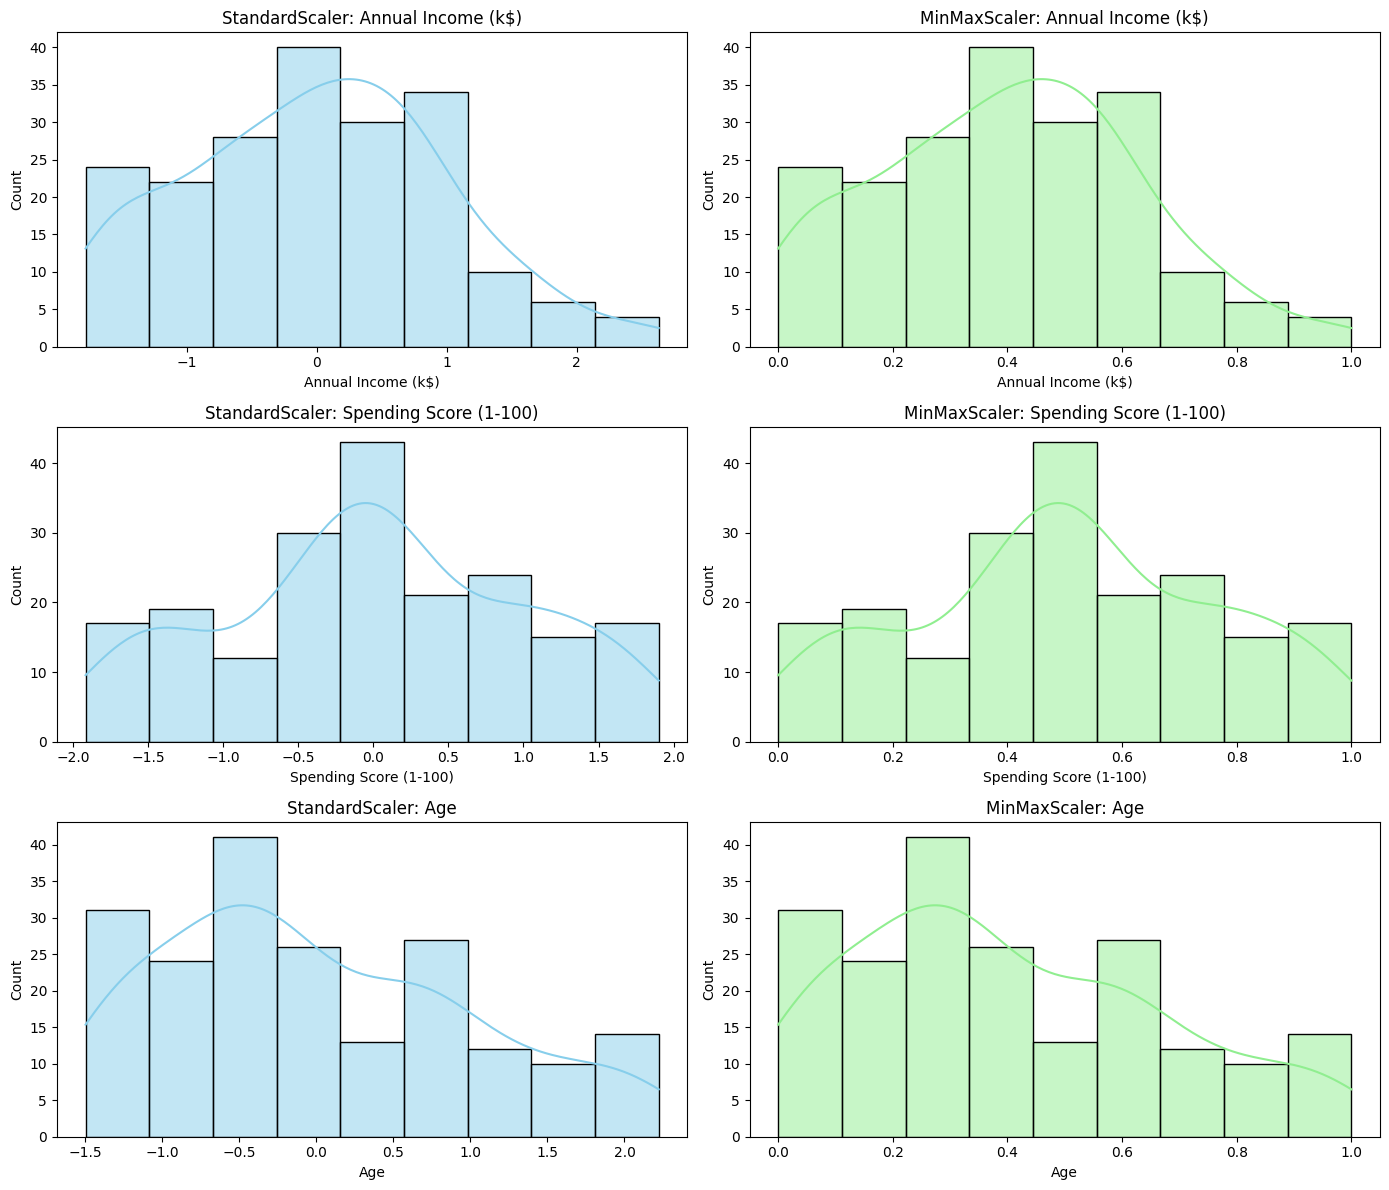

In [444]:
# Plot Histograms Side-by-Side for Each Scaler
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, feature in enumerate(numerical_features):
    # StandardScaler Plot
    sns.histplot(data_standard[feature], kde=True, color='skyblue', ax=axes[i, 0])
    axes[i, 0].set_title(f'StandardScaler: {feature}')

    # MinMaxScaler Plot
    sns.histplot(data_minmax[feature], kde=True, color='lightgreen', ax=axes[i, 1])
    axes[i, 1].set_title(f'MinMaxScaler: {feature}')

plt.tight_layout()
plt.show()

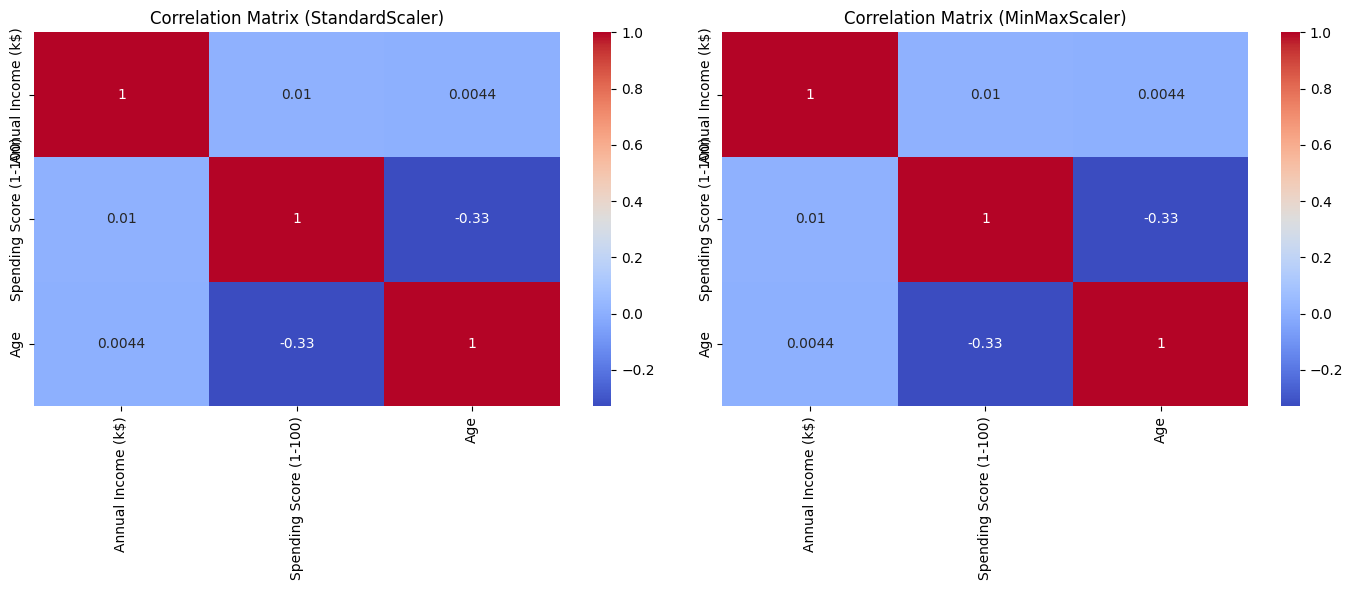

In [445]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation Matrix with StandardScaler
corr_standard = data_standard[numerical_features].corr()
sns.heatmap(corr_standard, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix (StandardScaler)')

# Correlation Matrix with MinMaxScaler
corr_minmax = data_minmax[numerical_features].corr()
sns.heatmap(corr_minmax, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix (MinMaxScaler)')

plt.tight_layout()
plt.show()

In [446]:
plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='Annual Income',
    y='Spending Score',
    data=data_standard[data_standard['Gender_Female'] == 1],
    label='Female (StandardScaler)',
    color='skyblue'
)
sns.scatterplot(
    x='Annual Income',
    y='Spending Score',
    data=data_standard[data_standard['Gender_Male'] == 1],
    label='Male (StandardScaler)',
    color='blue'
)
plt.title('StandardScaler: Annual Income vs Spending Score')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='Annual Income',
    y='Spending Score',
    data=data_minmax[data_minmax['Gender_Female'] == 1],
    label='Female (MinMaxScaler)',
    color='lightgreen'
)
sns.scatterplot(
    x='Annual Income',
    y='Spending Score',
    data=data_minmax[data_minmax['Gender_Male'] == 1],
    label='Male (MinMaxScaler)',
    color='green'
)
plt.title('MinMaxScaler: Annual Income vs Spending Score')
plt.legend()
plt.show()

ValueError: Could not interpret value `Annual Income` for `x`. An entry with this name does not appear in `data`.

<Figure size 1400x600 with 0 Axes>

In [ ]:
sns.pairplot(data_standard[numerical_features + ['Gender_Female', 'Gender_Male']], diag_kind='kde')
plt.suptitle('Pair Plot (StandardScaler)', y=1.02)
plt.show()


sns.pairplot(data_minmax[numerical_features + ['Gender_Female', 'Gender_Male']], diag_kind='kde')
plt.suptitle('Pair Plot (MinMaxScaler)', y=1.02)
plt.show()

#Testing using different dataset

## PHASE 1
---------

## 1.1 Introduction

In this project, we aim to explore customer segmentation by applying various unsupervised learning techniques on a dataset containing customer information from a mall. The primary goal is to divide the customer base into meaningful segments that reveal valuable insights for marketing and business strategies.

The implementation of this project follows a structured approach, starting with a thorough understanding of the dataset and its attributes. Data cleaning techniques are applied to ensure the data is accurate, consistent, and free from anomalies. Outliers are detected and handled appropriately to avoid skewing the analysis. Several clustering methods are employed to group customers.

To enhance the understanding of the results, a variety of visualization methods are used to represent the data and clustering outputs. The project also emphasizes experimentation with different preprocessing techniques and clustering models, including those not covered in the coursework, to improve accuracy and explore innovative approaches.

Through this comprehensive analysis, the project aims to demonstrate the power of data mining techniques in extracting actionable insights from raw data and highlight the importance of customer segmentation in modern business practices.

## 1.2 Preprocessing

### 1.2.1 imports

In [ ]:
pip install numpy pandas scikit-learn apyori pyfpgrowth seaborn matplotlib scipy scikit-learn-extra

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.mixture import GaussianMixture

from apyori import apriori
import pyfpgrowth
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import fcluster

### 1.2.2 loading data

In [ ]:
df = pd.read_csv('Shopping Mall Customer Segmentation Data .csv')

# Randomly sample 3000 rows
df = df.sample(n=300, random_state=42)  # Use random_state for reproducibility

# Check the new dataset
print(df.shape)


In [ ]:
print(df.head())
print(df.info())
print(df.describe())

In [ ]:
data = df.drop(columns=['Customer ID'])
data.head()

In [ ]:
# no missing data

if data.isnull().sum().sum() == 0:
    print("No missing values detected.")
else:
    print("Missing values detected. Handling them...")

### 1.2.3 General observation


   - The average customer age is around 56 years and Customer ages vary by about 14 years from the average.
   - The average annual income of customers is about $110876 and it varies by approximately $26,260 from the average
   - The average spending score is approximately 50 (mid-range) and vary by about 26 points from the average
   - 75% of the data falls below (third quartile).
   - Customers have a wide age range (18–90), indicating diversity in the customer base.
   - Annual incomes range from $21016 to $199890, showing significant financial diversity.
   - Spending scores vary from 2 to 100, indicating customers with both minimal and very high engagement.
   - The mean spending score (50) indicates a balanced spending behavior overall.

## 1.3 Outliers Detection and Removal

### 1.3.1 Detection

In [ ]:
male_count = data[data["Gender"] == "Male"].shape[0]
print(male_count)
Female_count = data[data["Gender"] == "Female"].shape[0]
print(Female_count)

In [ ]:
# Boxplots for Outlier Detection
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data['Annual Income'], ax=axes[0], color='skyblue')
axes[0].set_title('Outliers in Annual Income')

sns.boxplot(data['Spending Score'], ax=axes[1], color='lightgreen')
axes[1].set_title('Outliers in Spending Score')

sns.boxplot(data['Age'], ax=axes[2], color='salmon')
axes[2].set_title('Outliers in Age')

plt.tight_layout()
plt.show()

In [ ]:
def detect_outliers_zscore(data, column_name, ax):
    # Calculate Z-scores
    data['z_score'] = (data[column_name] - data[column_name].mean()) / data[column_name].std()

    # Identify outliers as data points with |Z-score| > 3
    outliers = data[np.abs(data['z_score']) > 3]

    # Plot the distribution and highlight outliers
    sns.histplot(data[column_name], bins=30, kde=True, color='blue', label='Data Distribution', ax=ax)
    ax.scatter(outliers[column_name], [0] * len(outliers), color='red', label='Outliers', s=100, zorder=3)
    ax.set_title(f'Distribution of {column_name} with Outliers')
    ax.set_xlabel(column_name)
    ax.set_ylabel('Frequency')
    ax.legend()

    # Drop Z-score column for cleanliness
    data.drop(columns=['z_score'], inplace=True)

    return outliers


# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of features to check for outliers
features_to_check = ['Annual Income', 'Spending Score', 'Age']

# Dictionary to store outliers
outliers_dict = {}

# Loop through each feature and plot side by side
for i, feature in enumerate(features_to_check):
    outliers = detect_outliers_zscore(data, feature, axes[i])
    outliers_dict[feature] = outliers

# Show all plots
plt.tight_layout()
plt.show()

### 1.3.2 Observations after outliers detection

The distribution is relatively uniform with slight variations, though there are peaks at specific income ranges such as $75,000 and $175,000.
Outliers are marked in red, with some data points falling significantly below $25,000 or above $200,000.
The blue curve represents the overall density of the data distribution.
Distribution of Spending Score with Outliers:

The spending score demonstrates a bimodal distribution, with noticeable peaks around scores of 20 and 80.
Outliers are observed at the extremes, near scores of 0 and 100.
The density curve highlights the concentration of spending scores around the two peaks.
Distribution of Age with Outliers:

The age distribution is approximately uniform with slight fluctuations. Peaks are observed around the ages of 30 and 80.
Outliers are marked near the upper end of the range, with ages closer to 90.
The density curve reflects a relatively even spread of ages, with slight concentrations at certain intervals.

### 1.3.3 Removal

In [ ]:

# Function to calculate IQR bounds and filter outliers
def calculate_iqr_bounds(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return lower_bound, upper_bound

def filter_outliers(data, features, threshold=1.5):
    bounds = {}
    for feature in features:
        lower, upper = calculate_iqr_bounds(data, feature, threshold)
        bounds[feature] = (lower, upper)
        print(f"{feature}: Lower = {lower:.2f}, Upper = {upper:.2f}")
        data = data[(data[feature] >= lower) & (data[feature] <= upper)]
    return data, bounds

# Define features to analyze and the threshold for outliers
features = ['Annual Income', 'Spending Score', 'Age']
threshold = 1.5

# Load data and filter out outliers
print("\nBounds for each feature:")
data_cleaned, bounds = filter_outliers(data, features, threshold)

# Display the number of rows before and after removing outliers
print(f"\nOriginal number of rows: {len(data)}")
print(f"Number of rows after removing outliers: {len(data_cleaned)}")

# Visualize cleaned data
sns.pairplot(data_cleaned, hue='Gender', diag_kind="kde", markers=["o", "s"])
plt.suptitle("Pairplot of Cleaned Data", y=1.02)
plt.show()


print("Data After Cleaning")
data_cleaned = pd.get_dummies(data_cleaned, columns=['Gender'])
data_cleaned.head()


data_cleaned_m=data_cleaned

## 1.4 Features Scalling

In [ ]:
label_encoder = LabelEncoder()
data_cleaned['Gender_Female'] = label_encoder.fit_transform(data_cleaned['Gender_Female'])
data_cleaned['Gender_Male'] = label_encoder.fit_transform(data_cleaned['Gender_Male'])
data_cleaned.head()

In [ ]:
data_standard = data_cleaned.copy()
data_minmax = data_cleaned.copy()

# Select numerical features to scale
numerical_features = ['Annual Income', 'Spending Score', 'Age']

# Apply StandardScaler
scaler_standard = StandardScaler()
data_standard[numerical_features] = scaler_standard.fit_transform(data_standard[numerical_features])

# Apply MinMaxScaler
scaler_minmax = MinMaxScaler()
data_minmax[numerical_features] = scaler_minmax.fit_transform(data_minmax[numerical_features])

In [ ]:
# Plot Histograms Side-by-Side for Each Scaler
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, feature in enumerate(numerical_features):
    # StandardScaler Plot
    sns.histplot(data_standard[feature], kde=True, color='skyblue', ax=axes[i, 0])
    axes[i, 0].set_title(f'StandardScaler: {feature}')

    # MinMaxScaler Plot
    sns.histplot(data_minmax[feature], kde=True, color='lightgreen', ax=axes[i, 1])
    axes[i, 1].set_title(f'MinMaxScaler: {feature}')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation Matrix with StandardScaler
corr_standard = data_standard[numerical_features].corr()
sns.heatmap(corr_standard, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix (StandardScaler)')

# Correlation Matrix with MinMaxScaler
corr_minmax = data_minmax[numerical_features].corr()
sns.heatmap(corr_minmax, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix (MinMaxScaler)')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='Annual Income',
    y='Spending Score',
    data=data_standard[data_standard['Gender_Female'] == 1],
    label='Female (StandardScaler)',
    color='skyblue'
)
sns.scatterplot(
    x='Annual Income',
    y='Spending Score',
    data=data_standard[data_standard['Gender_Male'] == 1],
    label='Male (StandardScaler)',
    color='blue'
)
plt.title('StandardScaler: Annual Income vs Spending Score')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='Annual Income',
    y='Spending Score',
    data=data_minmax[data_minmax['Gender_Female'] == 1],
    label='Female (MinMaxScaler)',
    color='lightgreen'
)
sns.scatterplot(
    x='Annual Income',
    y='Spending Score',
    data=data_minmax[data_minmax['Gender_Male'] == 1],
    label='Male (MinMaxScaler)',
    color='green'
)
plt.title('MinMaxScaler: Annual Income vs Spending Score')
plt.legend()
plt.show()

In [ ]:
sns.pairplot(data_standard[numerical_features + ['Gender_Female', 'Gender_Male']], diag_kind='kde')
plt.suptitle('Pair Plot (StandardScaler)', y=1.02)
plt.show()


sns.pairplot(data_minmax[numerical_features + ['Gender_Female', 'Gender_Male']], diag_kind='kde')
plt.suptitle('Pair Plot (MinMaxScaler)', y=1.02)
plt.show()

## PHASE 2
----------------------------------------------------------------------------------------------

## 2.1 Clustering Models

### 2.1.1 K-Mean clustering

In [ ]:

def kmeans_clustering(data, numerical_features, cluster_values, feature_pairs):
    # Create a grid of subplots
    fig, axes = plt.subplots(len(feature_pairs), len(cluster_values),
                             figsize=(18, 12), constrained_layout=True)
    fig.suptitle('KMeans Clustering Results Across Parameter Grid', fontsize=16)

    # Loop through feature pairs and cluster values
    for i, pair in enumerate(feature_pairs):
        for j, n_clusters in enumerate(cluster_values):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            data['KMeans_Labels'] = kmeans.fit_predict(data[pair])

            # Plot on the corresponding subplot
            ax = axes[i, j]
            scatter = ax.scatter(
                data[pair[0]],
                data[pair[1]],
                c=data['KMeans_Labels'],
                cmap='viridis',
                s=50,
                edgecolor='k'
            )
            ax.set_title(f'{pair[0]} vs {pair[1]} (k={n_clusters})', fontsize=10)
            ax.set_xlabel(pair[0], fontsize=9)
            ax.set_ylabel(pair[1], fontsize=9)
            ax.tick_params(axis='both', labelsize=8)

    # Add a shared colorbar to the figure
    fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04, label='Cluster')

    plt.show()

In [ ]:
cluster_values = [3, 4, 5]
feature_pairs = [
    ['Annual Income', 'Spending Score'],
    ['Age', 'Spending Score'],
    ['Annual Income', 'Age']
]

kmeans_clustering(data_minmax, numerical_features=['Annual Income', 'Spending Score'],
                  cluster_values=[3, 4, 5], feature_pairs=feature_pairs)

kmeans_clustering(data_standard, numerical_features=['Annual Income', 'Spending Score'],
                  cluster_values=[3, 4, 5], feature_pairs=feature_pairs)


### 2.1.2 DBSCAN clustering

  tring to ge the correct number of eps using KNN, but the results of the clustering wasnt affected anyway.

In [ ]:
X = data_cleaned[['Annual Income', 'Spending Score']]

ssd = []
silhouette_scores = []
n_clusters_range = range(2, 10)  # Possible number of clusters

for n_clusters in n_clusters_range:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    kmedoids_labels = kmedoids.fit_predict(X)
    ssd.append(kmedoids.inertia_)

    # Silhouette score
    if len(set(kmedoids_labels)) > 1:  # Valid clusters
        silhouette_scores.append(silhouette_score(X, kmedoids_labels))
    else:
        silhouette_scores.append(None)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, ssd, marker='o', label='Sum of Squared Distances (SSD)')
plt.xlabel('Number of Clusters')
plt.ylabel('SSD')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(n_clusters_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Clusters')
plt.legend()
plt.show()

from sklearn.neighbors import NearestNeighbors

# Compute the k-nearest neighbors
k = 4  # Choose min_samples
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# Sort distances for the k-distance plot
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(8, 4))
plt.plot(distances, label="k-distance (k=4)")
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('k-Distance Graph for Selecting eps')
plt.axhline(y=0.5, color='r', linestyle='--', label='Possible eps (0.5)')
plt.legend()
plt.show()

In [ ]:
data_standard = data_cleaned.copy()
data_minmax = data_cleaned.copy()

# Select numerical features to scale
numerical_features = ['Annual Income', 'Spending Score', 'Age']

# Apply StandardScaler
scaler_standard = StandardScaler()
data_standard[numerical_features] = scaler_standard.fit_transform(data_standard[numerical_features])

# Apply MinMaxScaler
scaler_minmax = MinMaxScaler()
data_minmax[numerical_features] = scaler_minmax.fit_transform(data_minmax[numerical_features])

In [ ]:
def dbscan_clustering(data, numerical_features, eps_values, min_samples_values):
    X = data[numerical_features]
    # Create a grid of subplots
    fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(20, 12))
    fig.suptitle('DBSCAN Clustering Results Across Parameter Grid', fontsize=16, y=1.02)
    # Looping over eps and min_samples combinations
    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(X)
            data['DBSCAN_Labels'] = dbscan_labels
            # Handle empty clusters (all -1 labels)
            unique_labels = np.unique(dbscan_labels)
            if len(unique_labels) == 1 and unique_labels[0] == -1:
                cluster_title = f"No clusters found (eps={eps}, min_samples={min_samples})"
            else:
                cluster_title = f'eps={eps}, min_samples={min_samples}'

            # Plot
            ax = axes[i, j]
            scatter = ax.scatter(
                data['Annual Income'],
                data['Spending Score'],
                c=data['DBSCAN_Labels'],
                cmap='plasma',
                s=50,
                edgecolor='k'
            )
            ax.set_title(cluster_title, fontsize=10)
            ax.set_xlabel('Annual Income', fontsize=9)
            ax.set_ylabel('Spending Score', fontsize=9)
            ax.tick_params(axis='both', labelsize=8)
    # Add a shared colorbar
    fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04, label='Cluster')
    plt.show()

In [ ]:
dbscan_clustering(data_standard, numerical_features=['Annual Income', 'Spending Score'],
                  eps_values=[ 0.01, 0.085, 0.09], min_samples_values=[2, 3, 4, 5])

dbscan_clustering(data_minmax, numerical_features=['Annual Income', 'Spending Score'],
                  eps_values=[ 0.08, 0.085, 0.09],min_samples_values = [2, 3, 4, 5])


#### **Observations**

* **Impact of `eps`:**
    * **Decreasing `eps`:** Leads to the formation of more, smaller clusters and an increase in the number of noise points (depicted in dark blue/purple). This is because the neighborhood radius shrinks, requiring points to be closer to form a cluster.
    * **Increasing `eps` :** Results in fewer, larger clusters. Points that were previously considered noise or part of separate clusters are now grouped together.

* **Impact of `min_samples`:**
    * **Increasing `min_samples` :**  Makes it harder for points to be considered core points. This results in a decrease in the number of core points, leading to fewer and more compact clusters. Some points that were part of clusters with lower `min_samples` are now classified as noise.
    * **Decreasing `min_samples`:** Makes it easier for points to be considered core points, potentially leading to the formation of more clusters and the inclusion of more points within existing clusters.

* **Noise Points:** The dark blue/purple points represent noise, meaning they do not belong to any cluster based on the specified parameter combination.


### 2.1.3 Agglomerative clustering

In [ ]:
def agglomerative_clustering(data1, data2, numerical_features, n_clusters_list, method):
    X1 = data1[numerical_features]
    X2 = data2[numerical_features]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Two rows: scatterplots & dendrograms

    # Iterate over datasets
    for idx, (X, dataset_label) in enumerate(zip([X1, X2], ['Standardized', 'Min-Max'])):
        for n_clusters in n_clusters_list:
            # Perform clustering
            agg_clust = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
            agg_labels = agg_clust.fit_predict(X)
            data = data1 if idx == 0 else data2
            data['Agg_Clust_Labels'] = agg_labels

            # Plot scatterplot
            axes[idx][0].scatter(
                data[numerical_features[0]],
                data[numerical_features[1]],
                c=data['Agg_Clust_Labels'], cmap='inferno', s=50
            )
            axes[idx][0].set_title(f'{dataset_label} Data: Agglomerative Clustering (n={n_clusters})')
            axes[idx][0].set_xlabel(numerical_features[0])
            axes[idx][0].set_ylabel(numerical_features[1])

            # Generate dendrogram
            linked = linkage(X, method=method)
            dendrogram(
                linked,
                truncate_mode='lastp',
                orientation='top',
                p=50,
                distance_sort='descending',
                show_leaf_counts=True,
                ax=axes[idx][1]
            )
            axes[idx][1].set_title(f'{dataset_label} Data: Dendrogram (Method: {method})')
            axes[idx][1].set_xlabel('Data Points')
            axes[idx][1].set_ylabel('Manhattan Distance')

    plt.tight_layout()
    plt.show()

In [ ]:
agglomerative_clustering(
    data1=data_standard,
    data2=data_minmax,
    numerical_features=['Annual Income', 'Spending Score'],
    n_clusters_list=[5],
    method='ward'
)

####2.1.3.1 Dendrogram using euclidean distance for Standard and MinMax scaled data

In [ ]:
# Euclidean Distance Dendrogram (using 'single')
single_euclidean = linkage(data_standard, method='single', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(single_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Single Linkage) with Standard Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(single_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")


# Euclidean Distance Dendrogram (using 'complete')
Complete_euclidean = linkage(data_standard, method='complete', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(Complete_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Complete Linkage) with Standard Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(Complete_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")


# Euclidean Distance Dendrogram (using 'average' linkage method)
Average_euclidean = linkage(data_standard, method='average', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(Average_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Average Linkage) with Standard Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_manhattan = fcluster(Average_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_manhattan))}")


In [ ]:
# Euclidean Distance Dendrogram (using 'ward')
linked_euclidean = linkage(data_standard, method='ward', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(linked_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Ward Linkage) with Standard scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(linked_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")

In [ ]:
# Euclidean Distance Dendrogram (using 'single')
single_euclidean = linkage(data_minmax, method='single', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(single_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Single Linkage) with MinMax Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(single_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")


# Euclidean Distance Dendrogram (using 'complete')
Complete_euclidean = linkage(data_minmax, method='complete', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(Complete_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Complete Linkage) with MinMax Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(Complete_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")


# Euclidean Distance Dendrogram (using 'average' linkage method)
Average_euclidean = linkage(data_minmax, method='average', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(Average_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Average Linkage) with MinMax Scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan
optimal_clusters_manhattan = fcluster(Average_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_manhattan))}")


In [ ]:
# Euclidean Distance Dendrogram (using 'ward')
linked_euclidean = linkage(data_minmax, method='ward', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(linked_euclidean, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Euclidean Distance - Ward Linkage) with MinMax scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Euclidean)')
plt.show()

# Determine optimal clusters for Euclidean
optimal_clusters_euclidean = fcluster(linked_euclidean, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Euclidean): {len(set(optimal_clusters_euclidean))}")

####2.1.3.2 Dendrogram using Manhattan distance for Standard and MinMax scaled data

In [ ]:
# Manhattan Distance Dendrogram (using 'single' linkage method)
linked_manhattan_single = linkage(data_standard, method='single', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(linked_manhattan_single, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Single Linkage) with Standard scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan (Single Linkage)
optimal_clusters_manhattan_single = fcluster(linked_manhattan_single, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan - Single Linkage): {len(set(optimal_clusters_manhattan_single))}")


# Manhattan Distance Dendrogram (using 'complete' linkage method)
linked_manhattan_complete = linkage(data_standard, method='complete', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(linked_manhattan_complete, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - complete Linkage) with Standard scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan (Complete Linkage)
optimal_clusters_manhattan_single = fcluster(linked_manhattan_single, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan - Single Linkage): {len(set(optimal_clusters_manhattan_single))}")


# Manhattan Distance Dendrogram (using 'average' linkage method)
average_manhattan = linkage(data_minmax, method='average', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(average_manhattan, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - average linkage) with MinMax scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan
optimal_clusters_manhattan = fcluster(average_manhattan, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_manhattan))}")


In [ ]:
# Manhattan Distance Dendrogram (using 'single')
single_Manhattan = linkage(data_minmax, method='single', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(single_Manhattan, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Single Linkage) with MinMax scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan
optimal_clusters_Manhattan = fcluster(single_Manhattan, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_Manhattan))}")


# Manhattan Distance Dendrogram (using 'complete')
Complete_Manhattan = linkage(data_minmax, method='complete', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(Complete_Manhattan, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Complete Linkage) with MinMax scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan
optimal_clusters_Manhattan = fcluster(Complete_Manhattan, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_Manhattan))}")


# Manhattan Distance Dendrogram (using 'average' linkage method)
Average_Manhattan = linkage(data_minmax, method='average', metric='cityblock')
plt.figure(figsize=(10, 7))
dendrogram(Average_Manhattan, truncate_mode='lastp', p=35, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Manhattan Distance - Average Linkage) with MinMax scaled data')
plt.xlabel('Data Points')
plt.ylabel('Dissimilarity (Manhattan)')
plt.show()

# Determine optimal clusters for Manhattan
optimal_clusters_manhattan = fcluster(Average_Manhattan, t=3, criterion='maxclust')
print(f"Optimal number of clusters (Manhattan): {len(set(optimal_clusters_manhattan))}")



 #### **Observations from Scatter Plots:**

* **Standardized Data:** The clusters appear more evenly distributed and separated in the standardized data plot. This is expected as standardization centers the data around zero and scales it to have unit variance, which can improve the performance of distance-based clustering algorithms.
* **Min-Max Scaled Data:** The clusters in the Min-Max scaled plot also show distinct groupings, but the visual separation between some clusters (e.g., the yellow and orange clusters on the left) seems less pronounced compared to the standardized data. This could be due to the scaling compressing the data into a 0-1 range, potentially reducing the relative distances between certain data points.
* **Cluster Consistency:** Despite the scaling differences, the overall shape and grouping of the clusters seem relatively consistent between the two scaling methods. Both methods identify similar core groups of data points.

#### **Observations from Dendrograms:**

* **Standardized Data Dendrogram:** The dendrogram for the standardized data exhibits clearer branching patterns at higher Euclidean distances. This indicates a more distinct hierarchical structure in the data after standardization. The long vertical lines before merging suggest relatively well-separated initial clusters.
* **Min-Max Scaled Data Dendrogram:** The dendrogram for the Min-Max scaled data shows merges occurring at lower Euclidean distances compared to the standardized data. This suggests that the data points are closer together in the scaled space, which is consistent with the visual observation from the scatter plot. The branching structure is also somewhat less pronounced than in the standardized data dendrogram.


### 2.1.4 K-Medoids clustering

In [ ]:

def kmedoids_clustering(data, numerical_features, cluster_values, feature_pairs, random_state=42):
    # Create a grid of subplots
    fig, axes = plt.subplots(len(feature_pairs), len(cluster_values), figsize=(18, 12), constrained_layout=True)
    fig.suptitle('K-Medoids Clustering Results Across Parameter Grid', fontsize=16)

    # Loop through feature pairs and cluster values
    for i, pair in enumerate(feature_pairs):
        for j, n_clusters in enumerate(cluster_values):
            # Initialize K-Medoids with the specified number of clusters
            kmedoids = KMedoids(n_clusters=n_clusters, random_state=random_state)
            data['KMedoids_Labels'] = kmedoids.fit_predict(data[pair])

            # Plot on the corresponding subplot
            ax = axes[i, j]
            scatter = ax.scatter(
                data[pair[0]],
                data[pair[1]],
                c=data['KMedoids_Labels'],
                cmap='viridis',
                s=50,
                edgecolor='k'
            )
            ax.set_title(f'{pair[0]} vs {pair[1]} (k={n_clusters})', fontsize=10)
            ax.set_xlabel(pair[0], fontsize=9)
            ax.set_ylabel(pair[1], fontsize=9)
            ax.tick_params(axis='both', labelsize=8)

            # Compute Silhouette Score for the current clustering
            silhouette_avg = silhouette_score(data[pair], data['KMedoids_Labels'])
            ax.text(0.95, 0.05, f'Silhouette: {silhouette_avg:.2f}', transform=ax.transAxes, fontsize=8,
                    verticalalignment='bottom', horizontalalignment='right', color='blue')

    # Add a shared colorbar to the figure
    fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04, label='Cluster')

    # Display the plot
    plt.show()


In [ ]:
cluster_values = [3, 4, 5]
feature_pairs = [
    ['Annual Income', 'Spending Score'],
    ['Age', 'Spending Score'],
    ['Annual Income', 'Age']
]

# Assuming `data_minmax` and `data_standard` are the datasets
kmedoids_clustering(data_minmax, numerical_features=['Annual Income', 'Spending Score'],
                    cluster_values=cluster_values, feature_pairs=feature_pairs)

kmedoids_clustering(data_standard, numerical_features=['Annual Income', 'Spending Score'],
                    cluster_values=cluster_values, feature_pairs=feature_pairs)



#### Observations and result
-
-
-

### 2.1.5 Gaussian Mixture Model

  this will be our model from outside the learnig scope, GMM is a more flexible alternative to algorithms like K-Means, especially when clusters are not spherical or when the dataset has varying densities, but in our dataset, there probably wont be much difference.


In [ ]:
def gmm_clustering(data, numerical_features, n_components_values, covariance_type_values):
    X = data[numerical_features]

    # Create a grid of subplots
    fig, axes = plt.subplots(len(n_components_values), len(covariance_type_values), figsize=(20, 12))
    fig.suptitle('Gaussian Mixture Model Clustering Results Across Parameter Grid', fontsize=16, y=1.02)

    # Looping over n_components and covariance_type combinations
    for i, n_components in enumerate(n_components_values):
        for j, covariance_type in enumerate(covariance_type_values):
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
            gmm_labels = gmm.fit_predict(X)
            data['GMM_Labels'] = gmm_labels

            # Handle empty clusters (if all points are assigned to the same component)
            unique_labels = np.unique(gmm_labels)
            if len(unique_labels) == 1:
                cluster_title = f"Single cluster (n_components={n_components}, covariance={covariance_type})"
            else:
                cluster_title = f'n_components={n_components}, covariance={covariance_type}'

            # Plot
            ax = axes[i, j]
            scatter = ax.scatter(
                data[numerical_features[0]],
                data[numerical_features[1]],
                c=data['GMM_Labels'],
                cmap='viridis',
                s=50,
                edgecolor='k'
            )
            ax.set_title(cluster_title, fontsize=10)
            ax.set_xlabel(numerical_features[0], fontsize=9)
            ax.set_ylabel(numerical_features[1], fontsize=9)
            ax.tick_params(axis='both', labelsize=8)

    # Add a shared colorbar
    fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04, label='Cluster')
    plt.show()

In [ ]:
gmm_clustering(data_standard, numerical_features=['Annual Income', 'Spending Score'],
                n_components_values=[4, 5], covariance_type_values=['full', 'tied', 'diag', 'spherical'])

gmm_clustering(data_minmax, numerical_features=['Annual Income', 'Spending Score'],
                n_components_values=[4, 5], covariance_type_values=['full', 'tied', 'diag', 'spherical'])